# Configuracion del entorno

In [2]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

Mounted at /content/gdrive
fastcore version 1.7.29 installed
fastai version 2.7.19 installed


In [3]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_label_counts(dls):
    # Extraer y convertir las etiquetas a enteros:
    train_labels = [int(dls.train_ds[i][1]) for i in range(len(dls.train_ds))]
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de elementos por etiqueta:
    train_counts = Counter(train_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos usando los índices (0, 1, ..., n_classes-1)
    train_data = [train_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2, train_data, width, label='Train', color='blue')
    ax.bar(x + width/2, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


# Apartado 1

Obtenemos los datos

In [5]:
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

try:
  path = untar_data(URLs.MNIST)
except Exception as e:
  print(f"Error al descargar el dataset: {e}")


Lo ordenamos correctamente con los path

In [6]:
# Definir rutas para la organización
base_path = Path('/content/dataset')
original_path = base_path / "original"

original_path.mkdir(parents=True, exist_ok=True)

dest_original = original_path / path.name
if not dest_original.exists():
    shutil.move(str(path), str(dest_original))
    print(f"Dataset movido a: {dest_original}")
else:
    print("El dataset ya se encuentra en la carpeta original.")

Dataset movido a: /content/dataset/original/mnist_png


Montamos el drive para que tenga acceso

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## LENET

Creamos el datablock para lenet

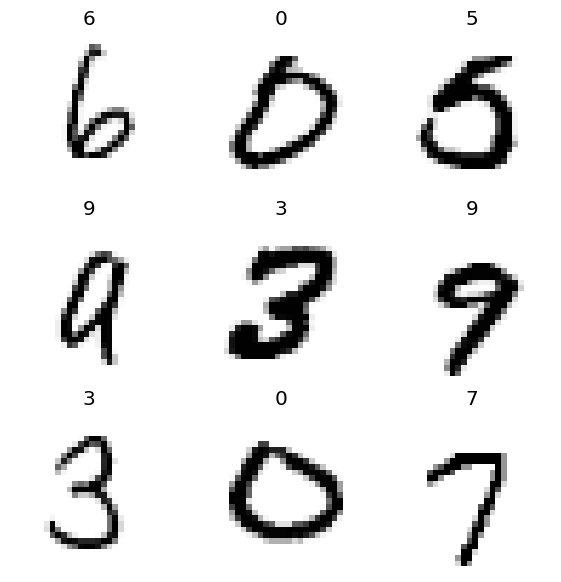

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 48000
Número total de imágenes en validación: 12000

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


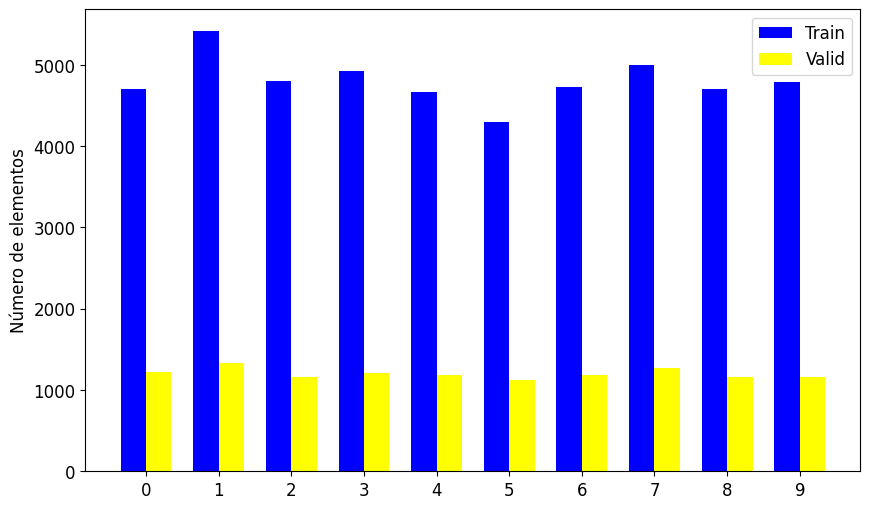

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 9: early stopping

Tiempo de entrenamiento: 989.56 segundos


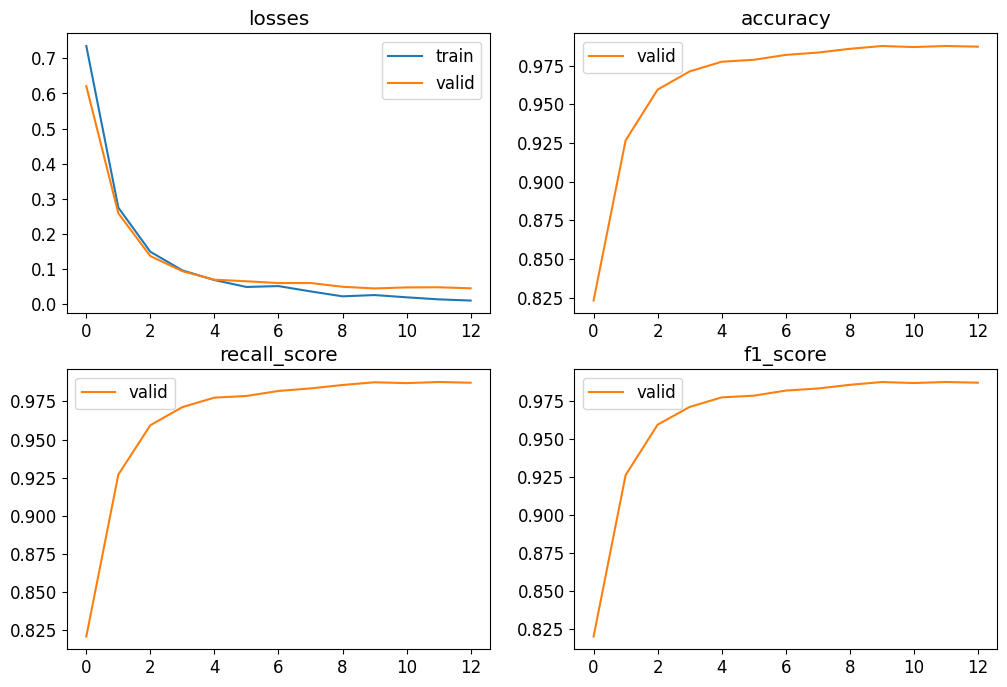

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0443
Accuracy: 0.9872
Recall: 0.9873
F1-Score: 0.9872


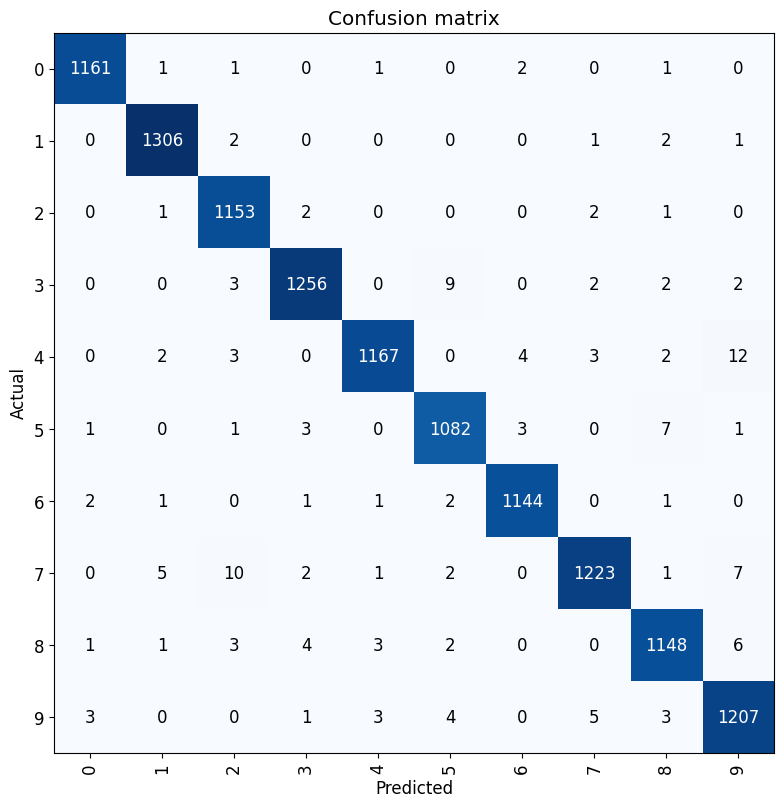

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

## Resnet

In [ ]:
original_path = Path("/content/dataset/original/mnist_png")

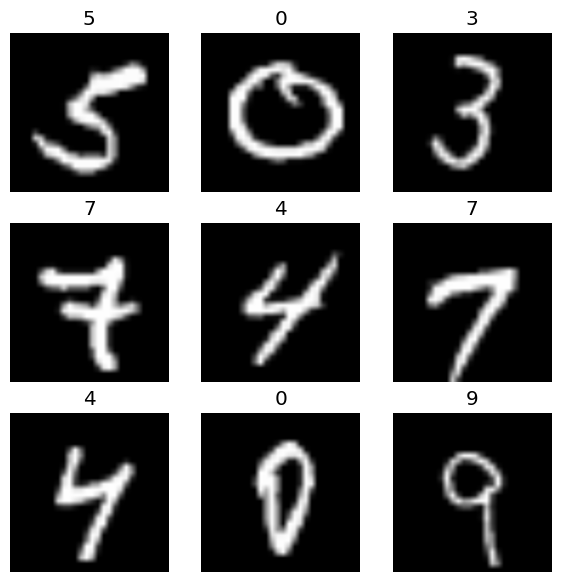

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(original_path/'training', bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 10: early stopping

Tiempo de entrenamiento: 2818.79 segundos


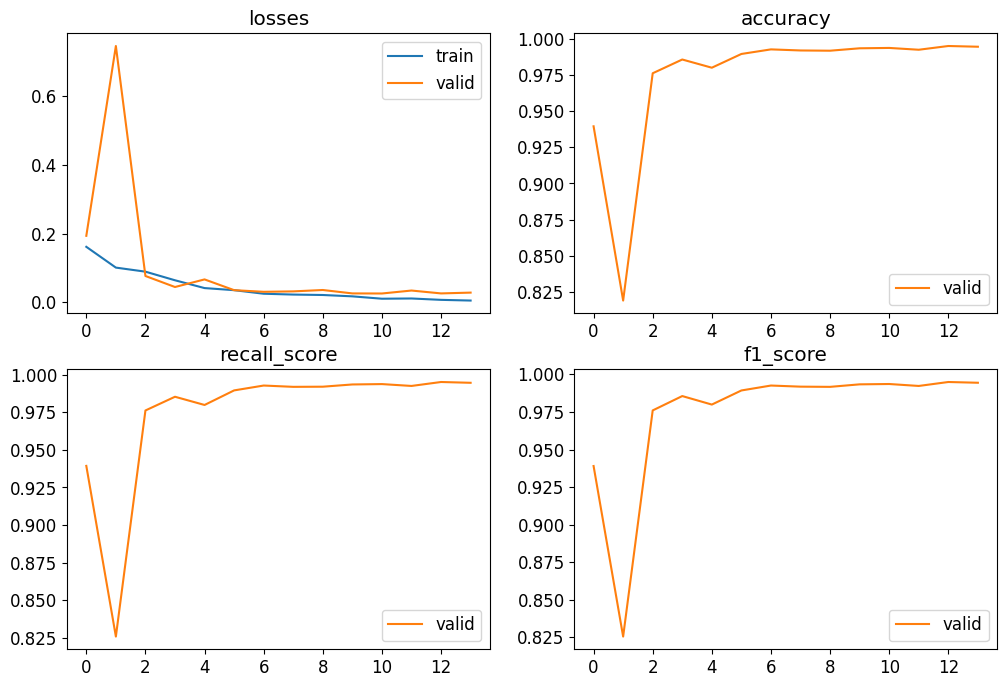

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0281
Accuracy: 0.9945
Recall: 0.9946
F1-Score: 0.9945


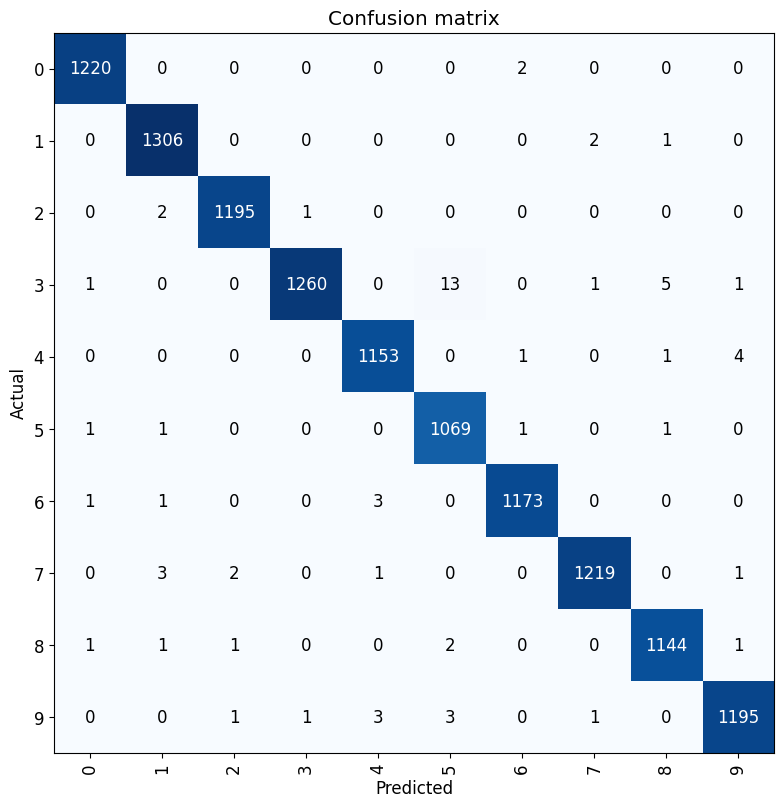

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

# Apartado 2

## Destilacion de datos

In [ ]:
original_path = base_path / "original"

mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

In [ ]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    # Sumar todas las imágenes (convertidas a array NumPy)
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    # Calcular la media y convertir a uint8
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image, mode='L')


In [ ]:
def create_distilled(src_path, dst_path, valid_ratio=0.2, fraction=0.2, mix_function=media_arit):
    """
    Genera un nuevo dataset a partir de la carpeta src_path.
    - Se crea una división: valid_ratio de las imágenes se destinan a validación (se copian sin modificar)
      y el resto (1 - valid_ratio) se destilan (agrupando imágenes según 'fraction').
    - Se espera que src_path tenga subcarpetas para cada clase.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Si ya existe la carpeta destino, se elimina
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear subcarpetas para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada carpeta de clase en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        images = list(class_dir.glob('*.*'))
        if len(images) == 0:
            continue

        # Barajar para una división aleatoria
        random.shuffle(images)
        n_total = len(images)
        n_valid = int(n_total * valid_ratio)
        n_train = n_total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Crear directorios para la clase en training y valid
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Para el training: destilamos usando el parámetro fraction
        if fraction == 0:  # Copiamos las imágenes originales
            for img_path in train_images:
                shutil.copy(img_path, new_train_class_dir)
        elif fraction == 1:  # Mezclamos todas las imágenes en una sola
            distilled_image = mix_function(train_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_image.save(distilled_filename)
        else:
            group_size = max(1, int(len(train_images) * fraction))
            group_count = 0
            for i in range(0, len(train_images), group_size):
                group = train_images[i:i + group_size]
                distilled_image = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_image.save(distilled_filename)
                group_count += 1

        # Para la validación: se copian las imágenes sin modificación
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.01, fraction=0.01, mix_function=media_arit)

In [ ]:
mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

create_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.005, fraction=0.05, mix_function=media_arit)

In [ ]:
mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

create_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.1, fraction=0.001, mix_function=media_arit)

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

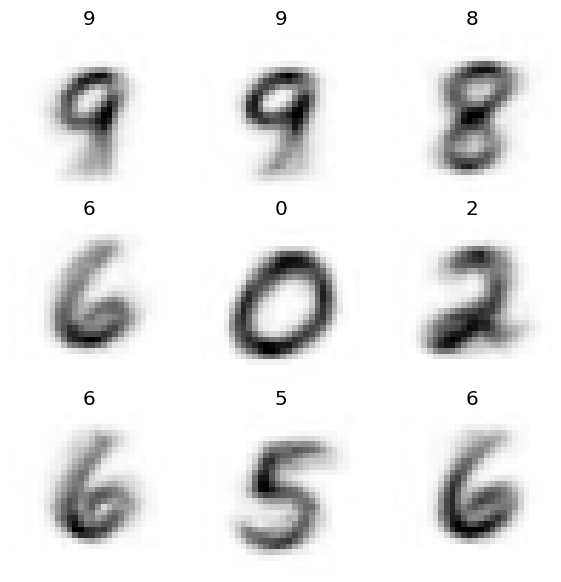

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 1019
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


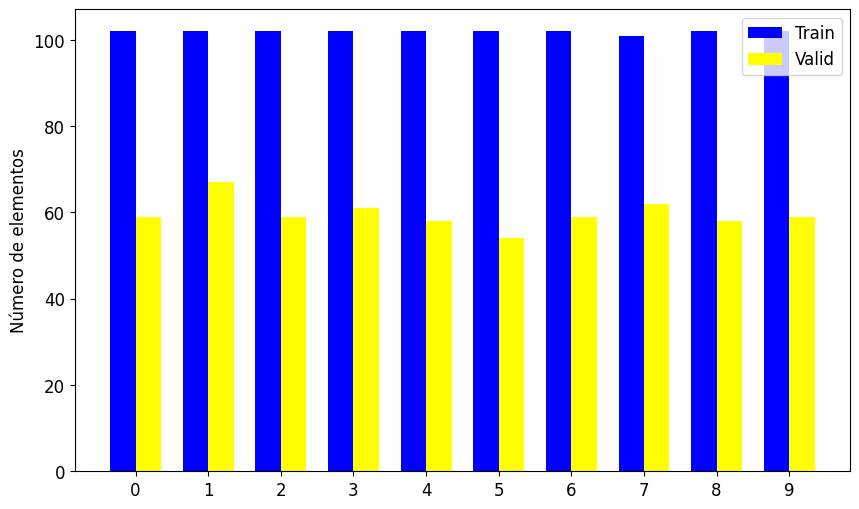

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 4: early stopping

Tiempo de entrenamiento: 16.17 segundos


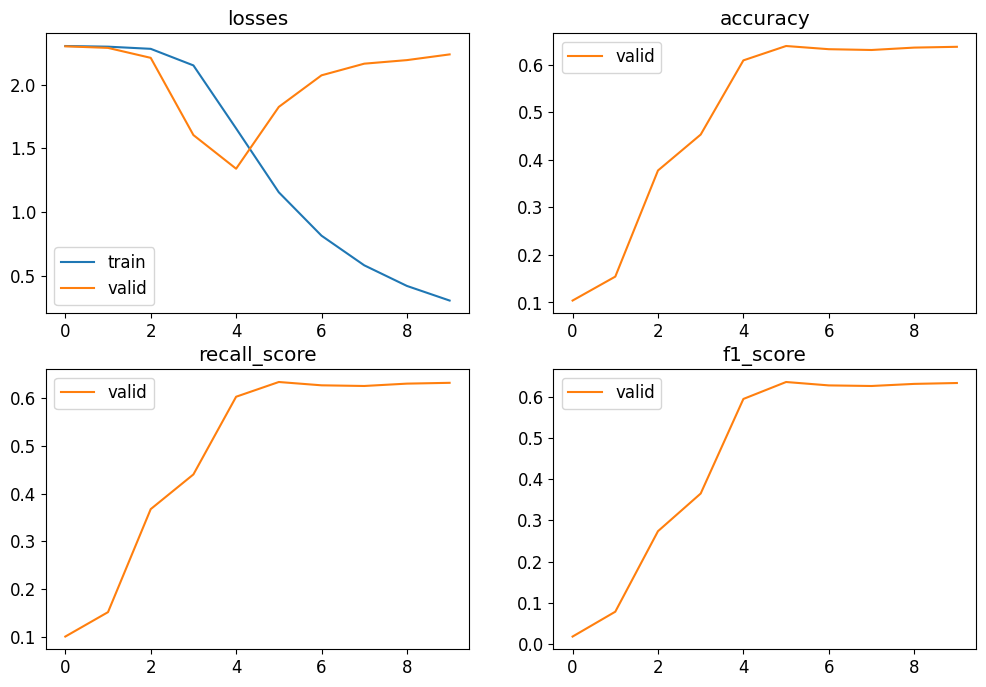

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4527
Accuracy: 0.7243
Recall: 0.7207
F1-Score: 0.7214


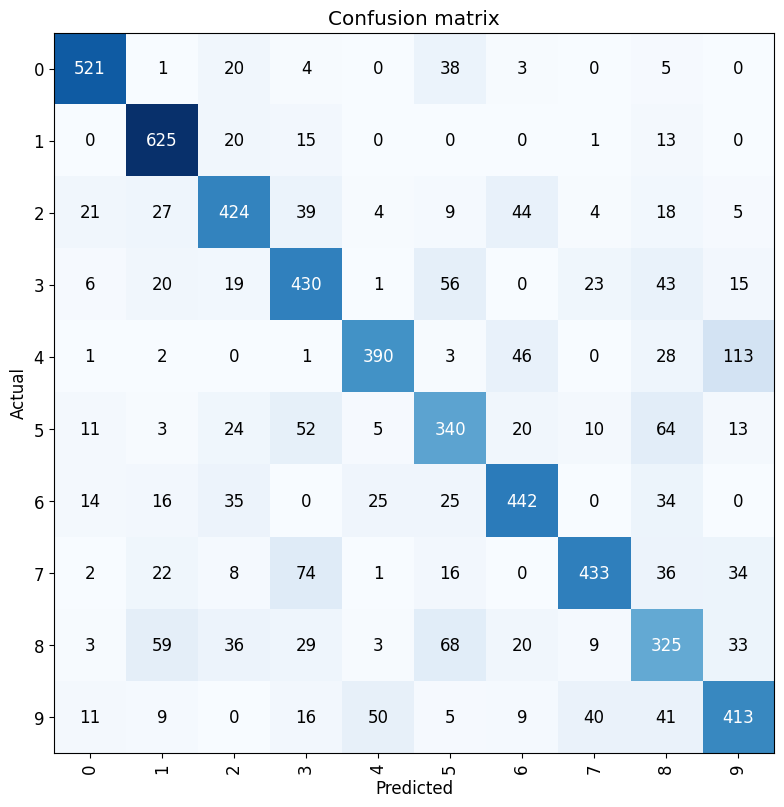

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_v3.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

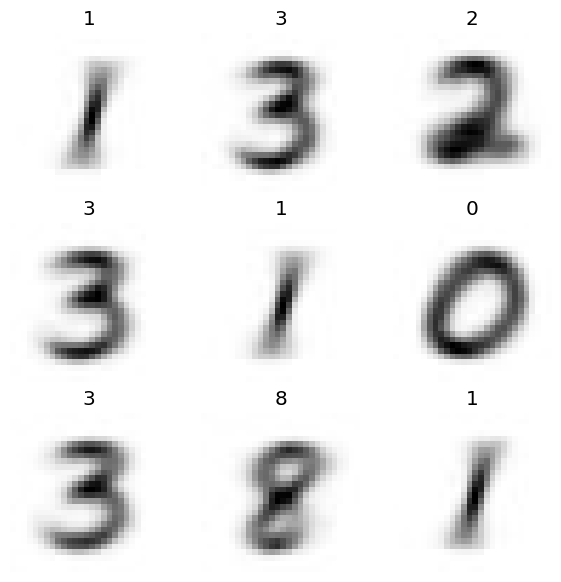

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 209
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


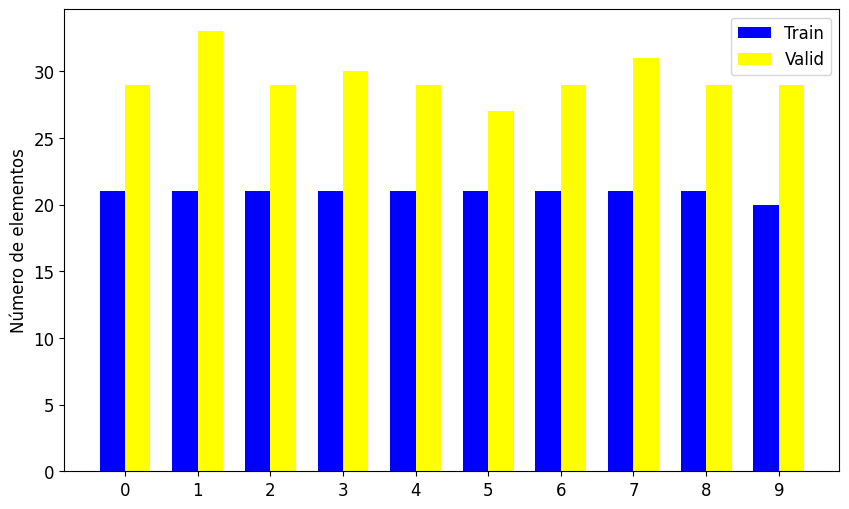

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(60)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 19: early stopping

Tiempo de entrenamiento: 17.89 segundos


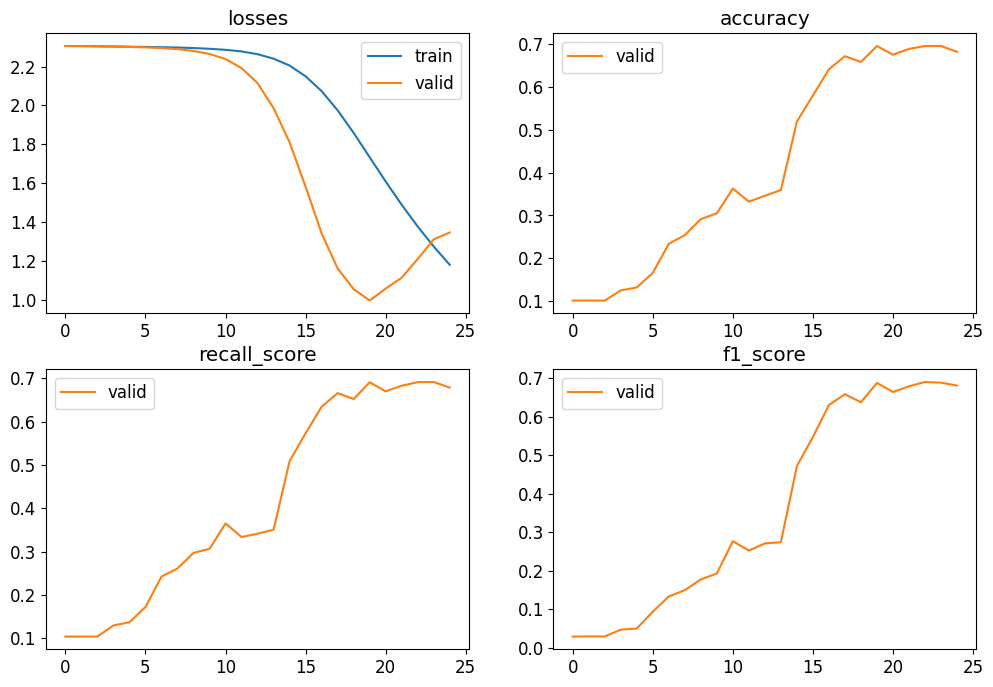

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3459
Accuracy: 0.6814
Recall: 0.6787
F1-Score: 0.6814


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_v3.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

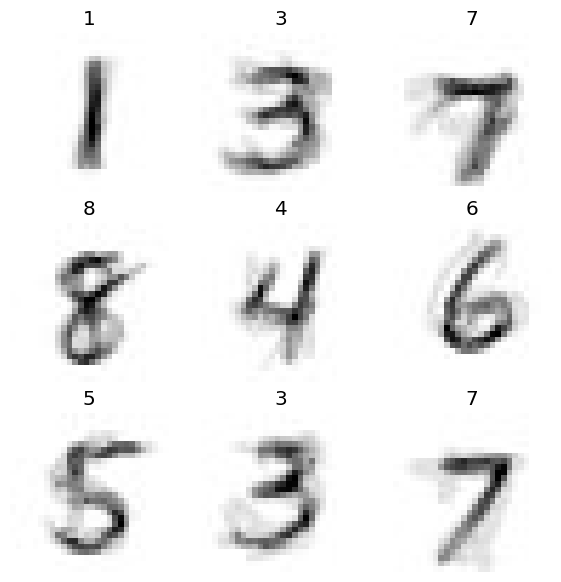

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 10847
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


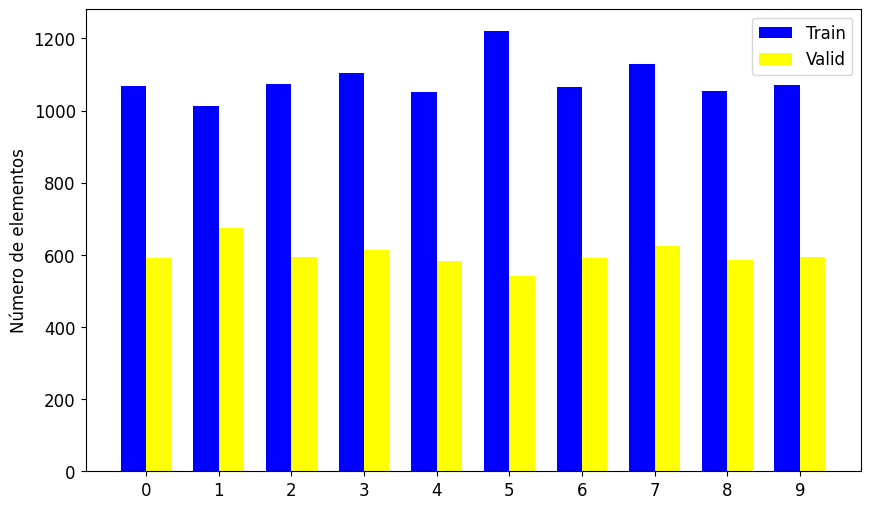

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 89.77 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9912
Accuracy: 0.8492
Recall: 0.8478
F1-Score: 0.8476


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_v3.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

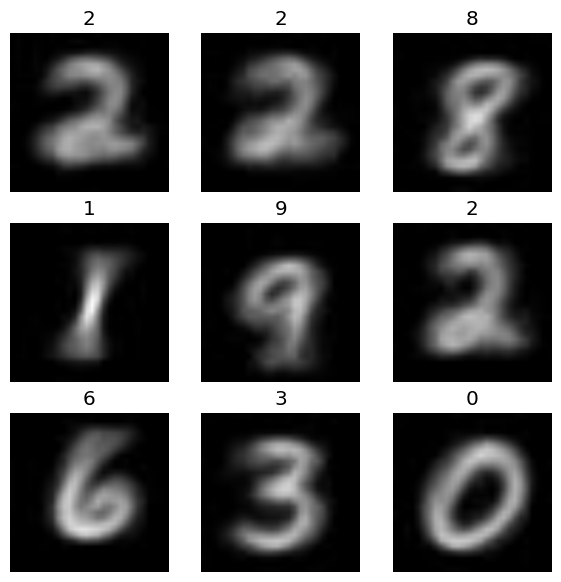

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=True)


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

Exception ignored in sys.unraisablehookException ignored in: Exception ignored in: <function _releaseLock at 0x7b59e83d2f20>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


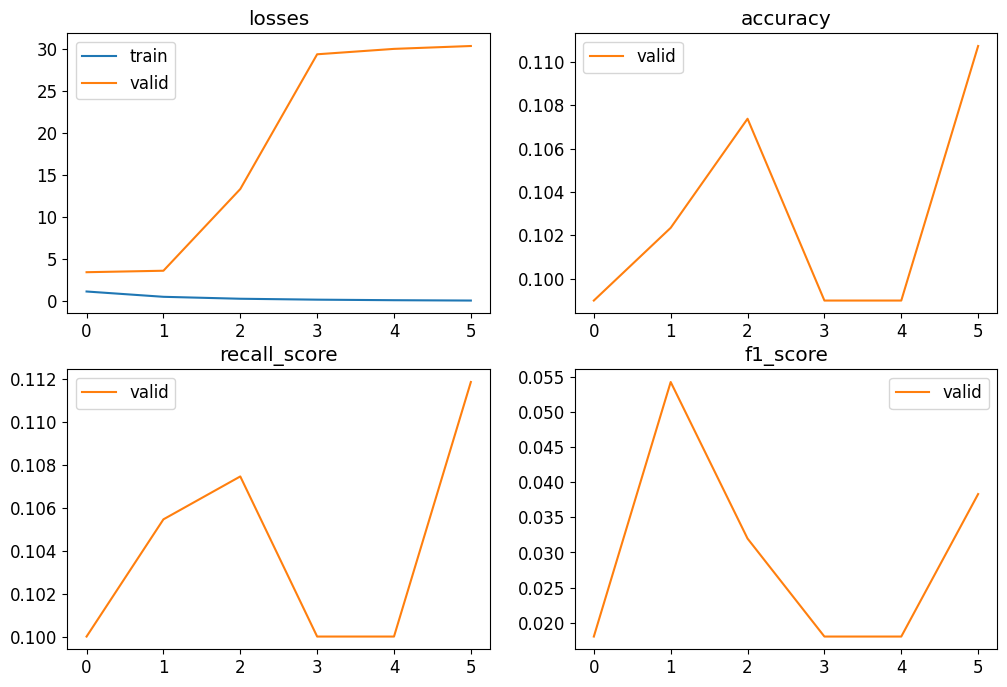

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 30.3840
Accuracy: 0.1107
Recall: 0.1119
F1-Score: 0.0383


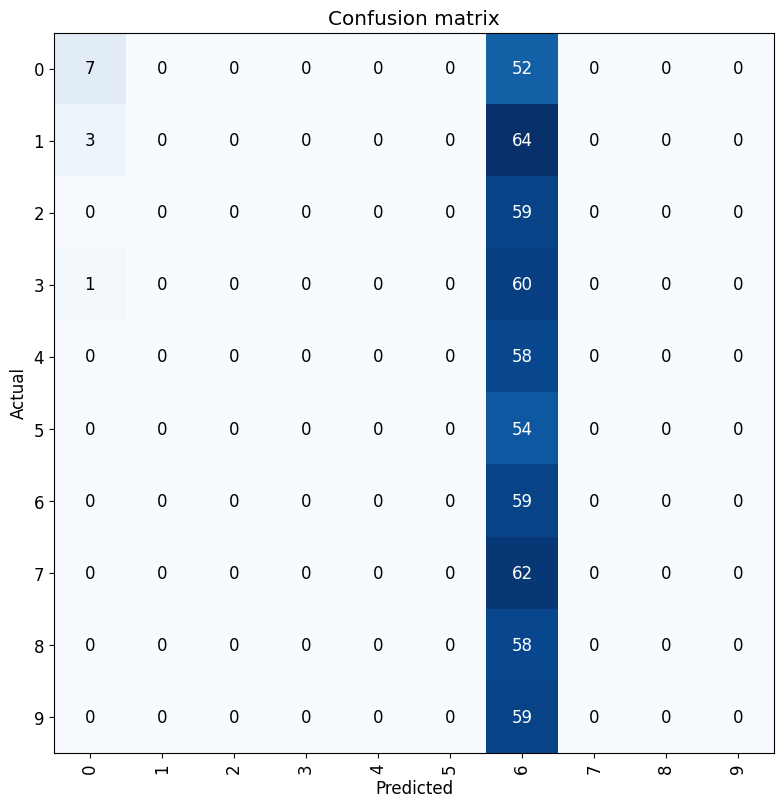

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_v3.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

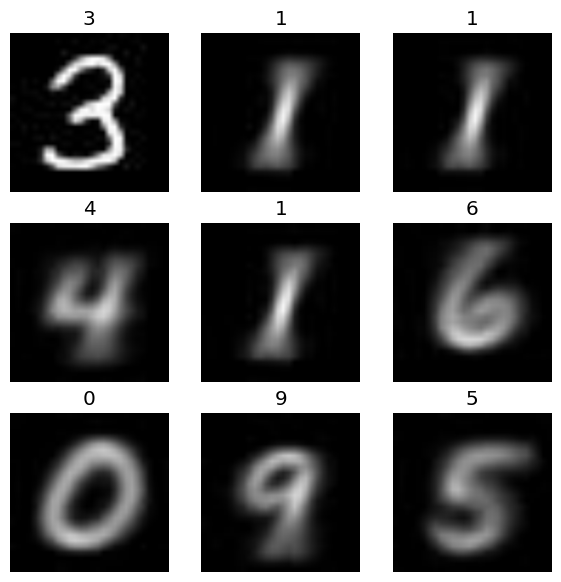

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(60)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 12.09 segundos


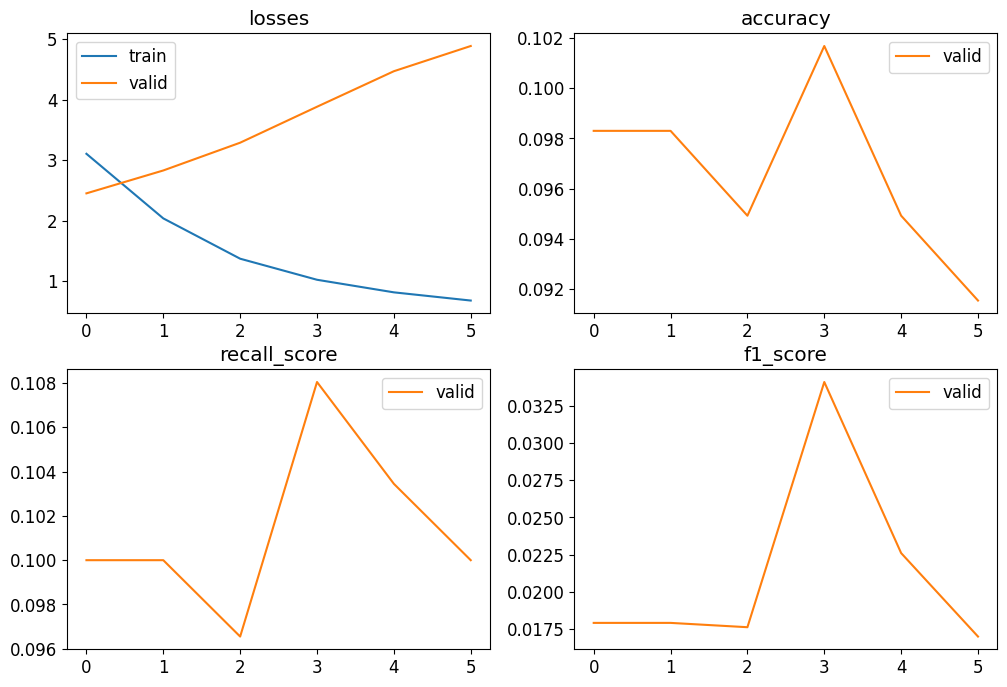

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.8911
Accuracy: 0.0915
Recall: 0.1000
F1-Score: 0.0170


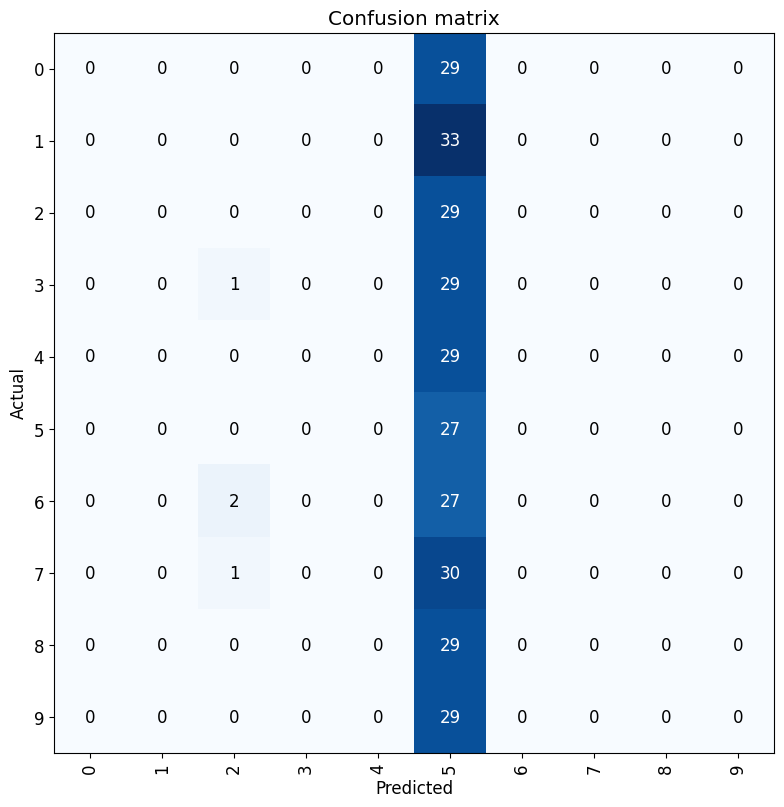

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_v3.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

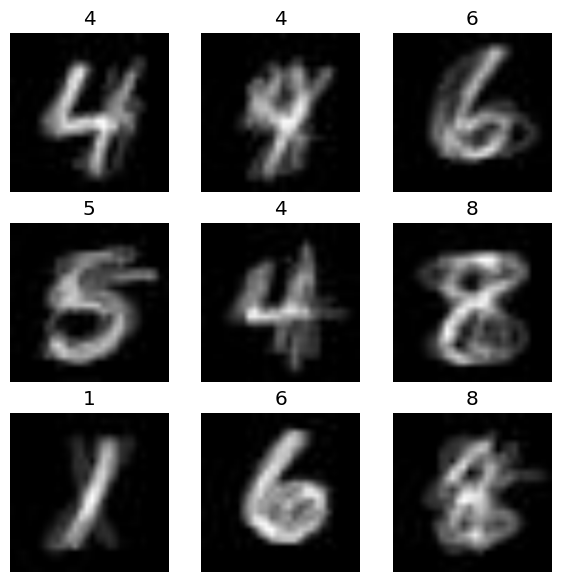

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(60)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 23: early stopping

Tiempo de entrenamiento: 1574.68 segundos


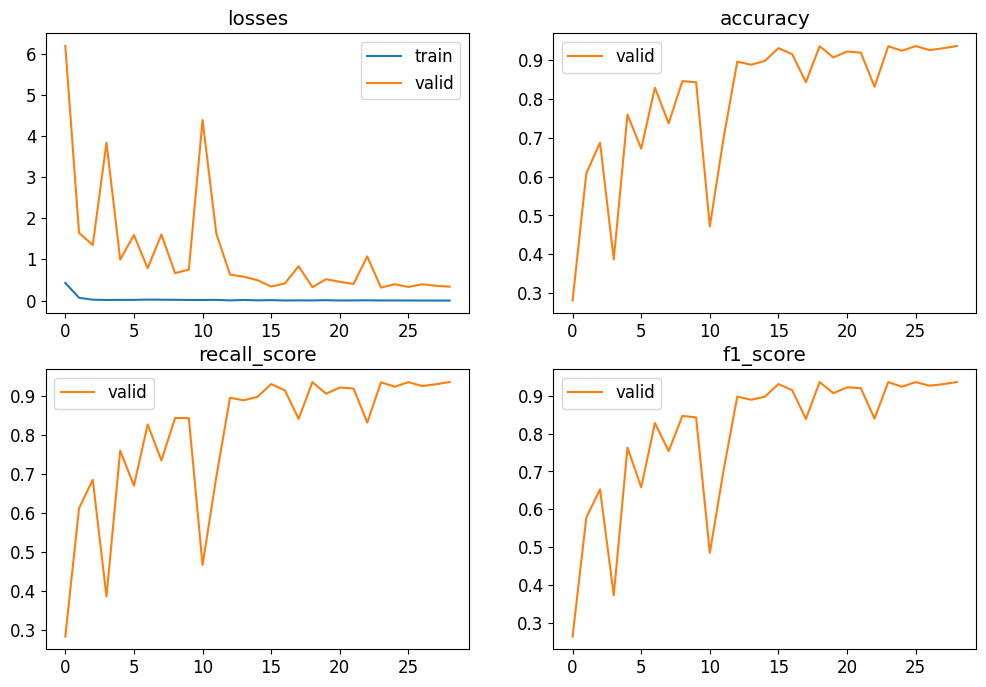

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3375
Accuracy: 0.9366
Recall: 0.9362
F1-Score: 0.9357


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_v3.pkl')

# Apartado 3

## Seleccion de examples

In [11]:
import random
def get_items_fraction(path, train_fraction=0.8):
    all_items = get_image_files(path)
    selected = []
    for item in all_items:
        if item.parts[-3].lower() == 'training':
            if random.random() < train_fraction:
                selected.append(item)
        else:
            selected.append(item)
    return selected

## Base - Lenet

Example 1

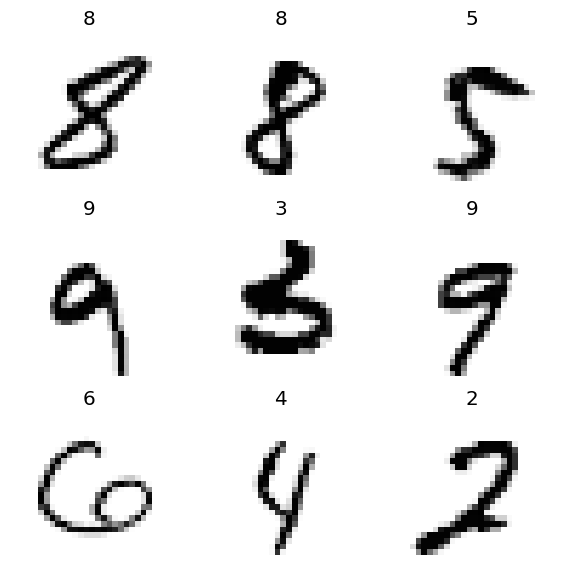

In [12]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2)
)

# Crear los DataLoaders
dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 38422
Número total de imágenes en validación: 9605

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


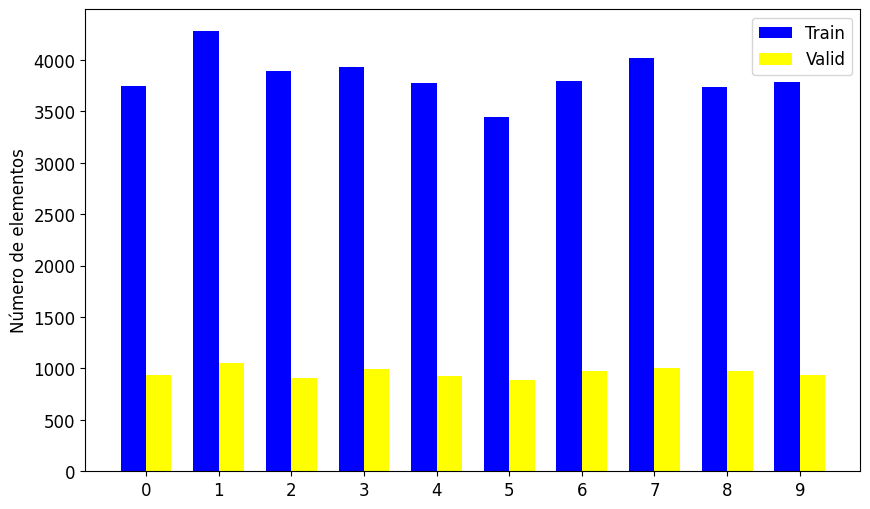

In [13]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 651.64 segundos


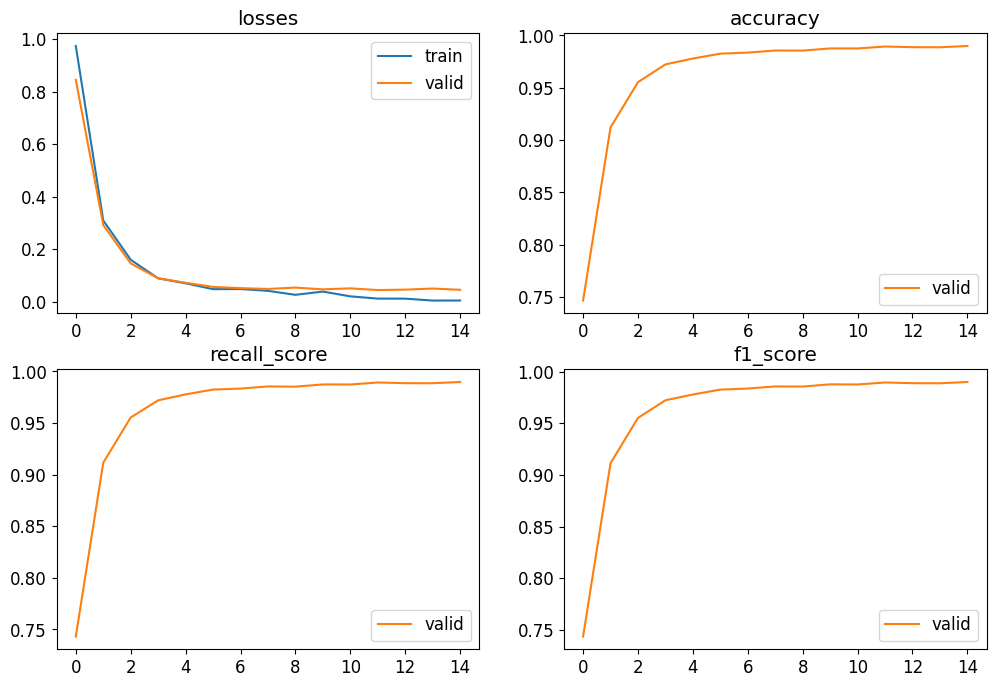

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0459
Accuracy: 0.9899
Recall: 0.9898
F1-Score: 0.9898


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_5cluster01_v3.pkl')

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

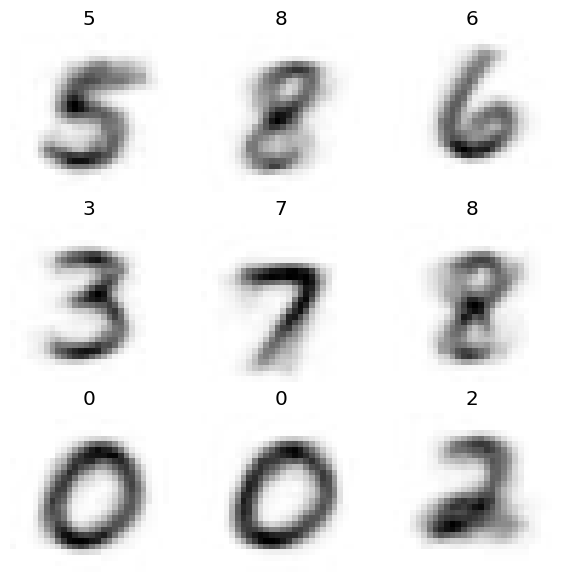

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 830
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


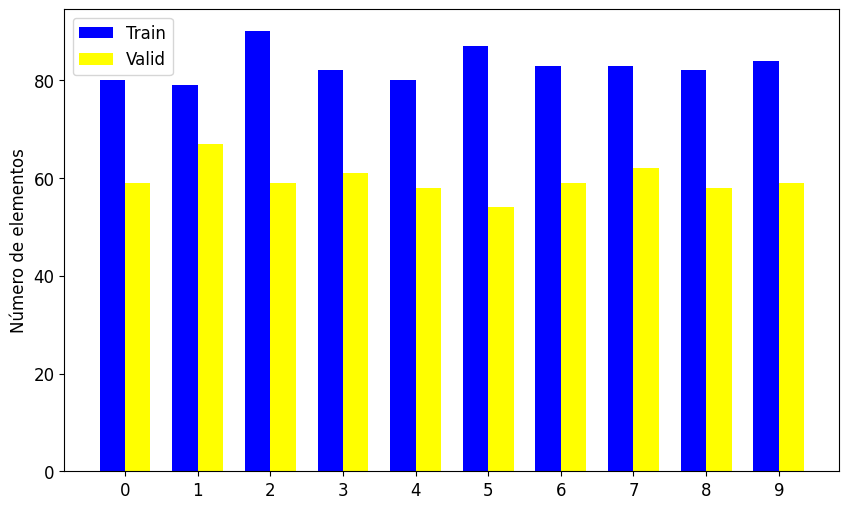

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 56.91 segundos


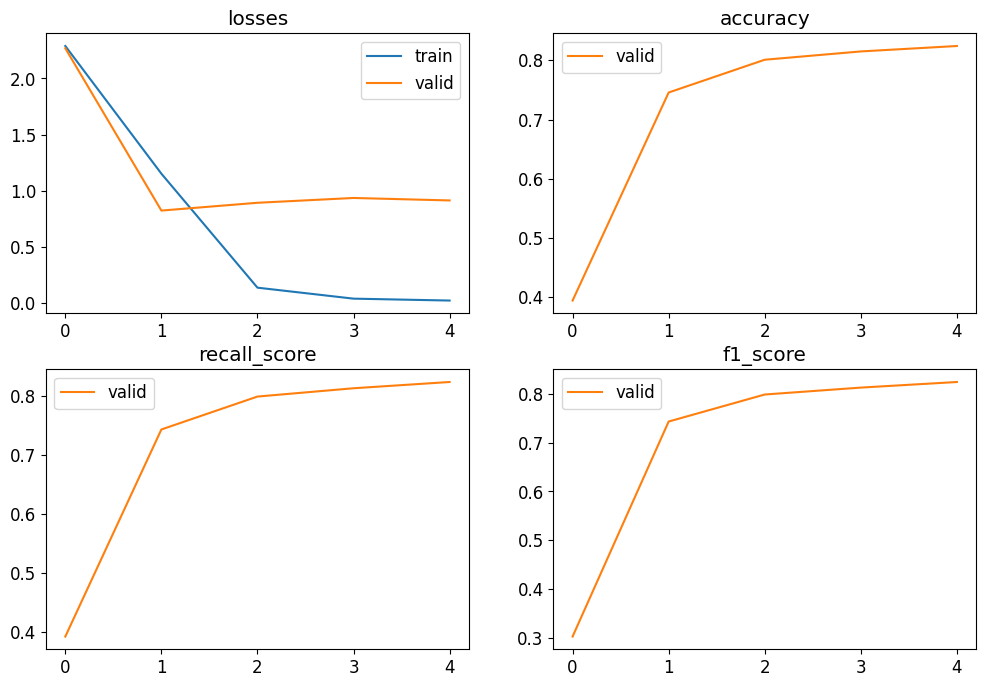

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9135
Accuracy: 0.8242
Recall: 0.8231
F1-Score: 0.8242


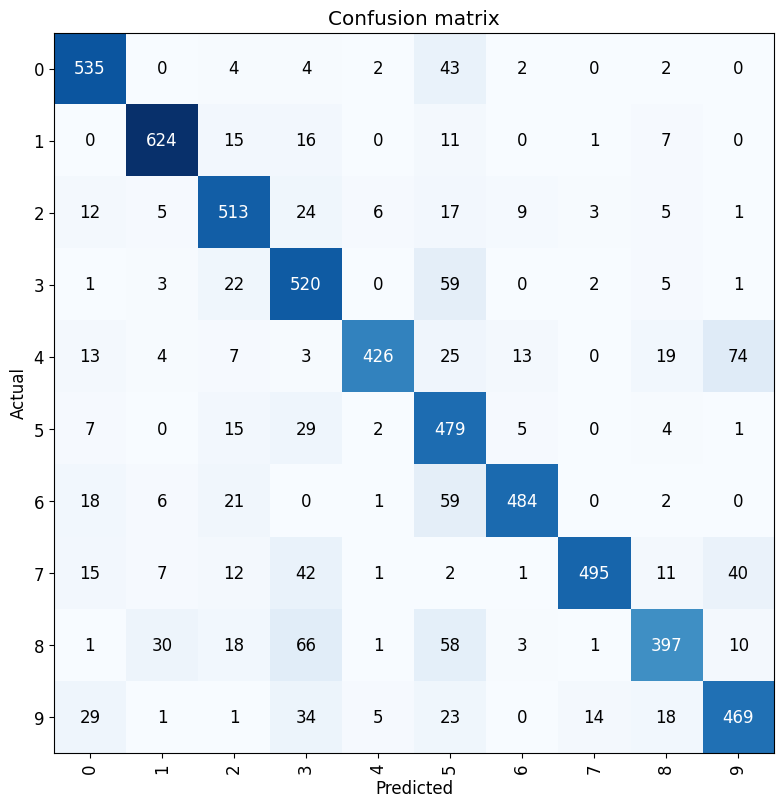

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v3.pkl')

Example 2

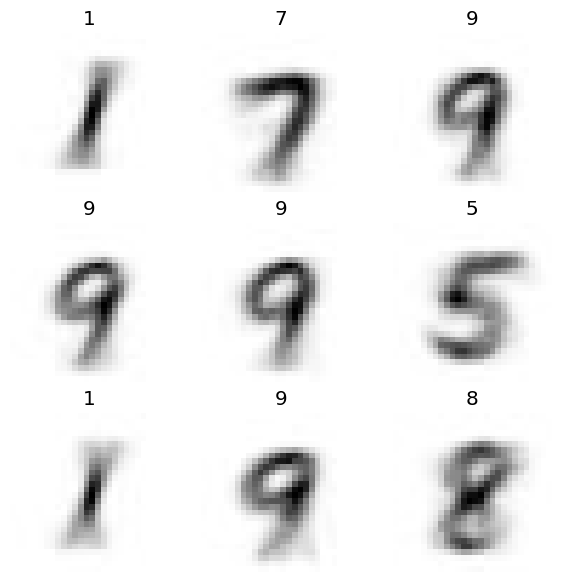

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 5: early stopping

Tiempo de entrenamiento: 11.53 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.7034
Accuracy: 0.6946
Recall: 0.6900
F1-Score: 0.6884


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v3.pkl')

Example 3

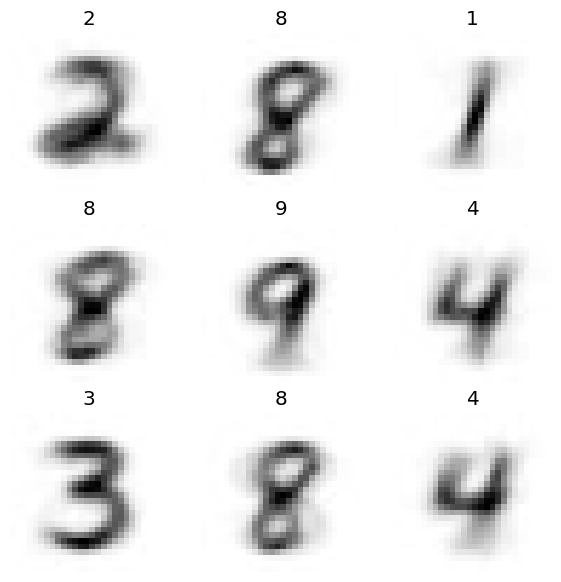

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 5: early stopping

Tiempo de entrenamiento: 11.46 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9704
Accuracy: 0.7936
Recall: 0.7910
F1-Score: 0.7936


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v3.pkl')

Example 4

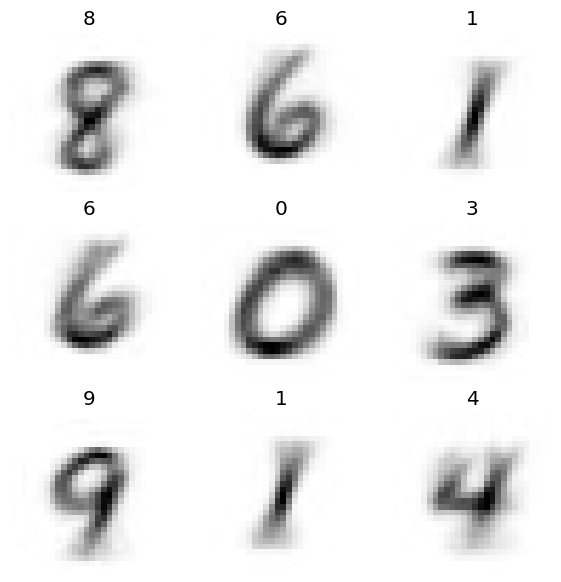

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 5: early stopping

Tiempo de entrenamiento: 16.02 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4366
Accuracy: 0.7131
Recall: 0.7090
F1-Score: 0.7099


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster04_v3.pkl')

eXAMPLE 5

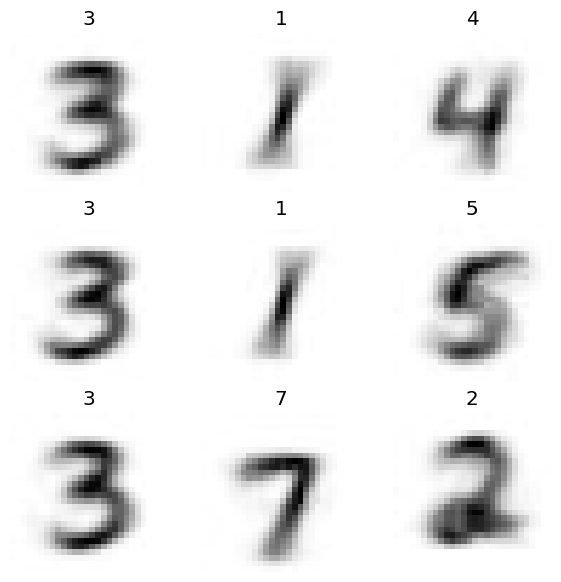

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 5: early stopping

Tiempo de entrenamiento: 13.05 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1997
Accuracy: 0.7282
Recall: 0.7244
F1-Score: 0.7278


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster05_v3.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

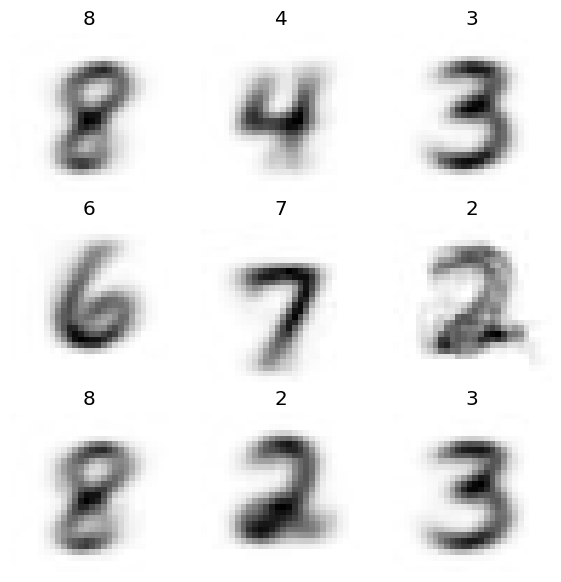

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 170
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


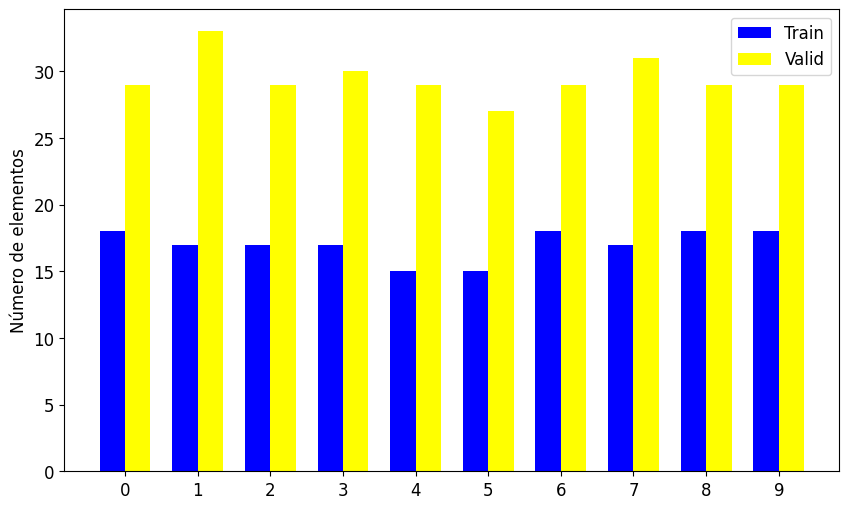

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 13.55 segundos


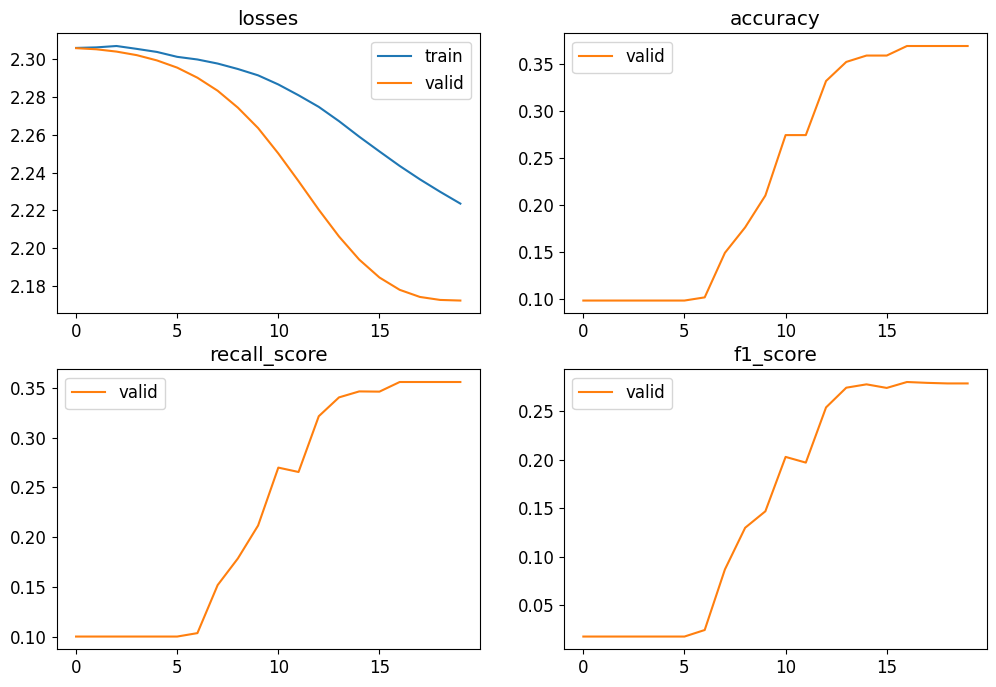

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.1722
Accuracy: 0.3695
Recall: 0.3559
F1-Score: 0.2783


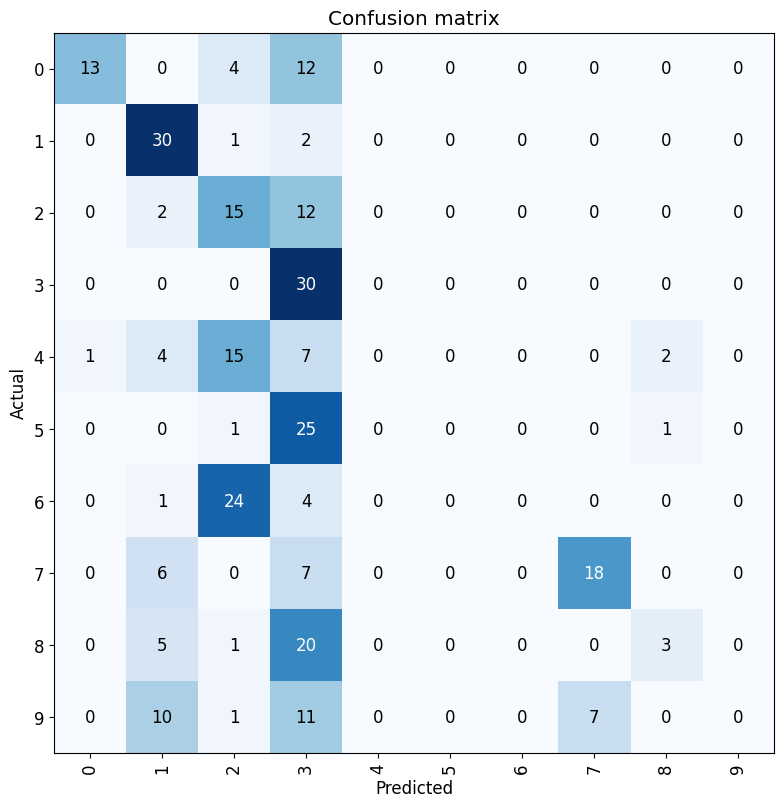

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v3.pkl')

Example 2

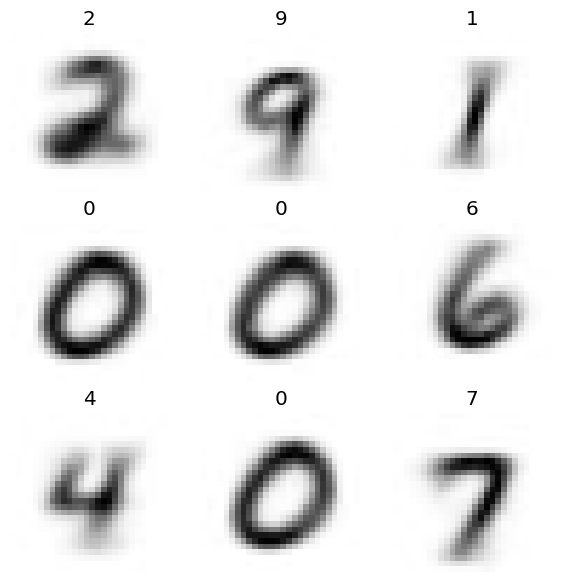

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.51 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.1686
Accuracy: 0.4576
Recall: 0.4506
F1-Score: 0.3805


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v3.pkl')

Example 3

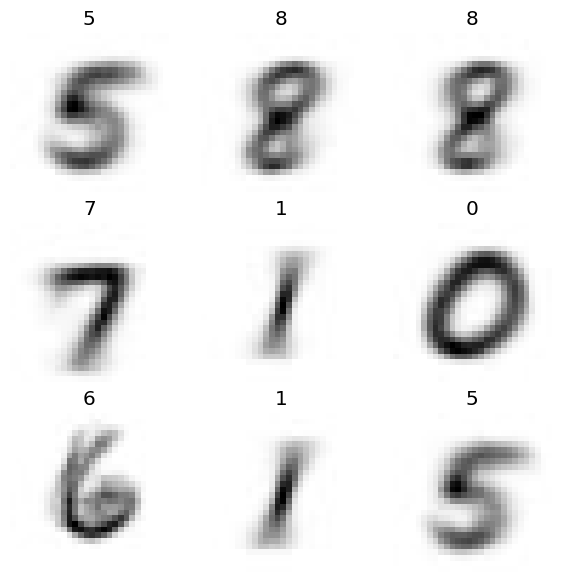

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 16.80 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.0798
Accuracy: 0.5492
Recall: 0.5397
F1-Score: 0.4953


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v3.pkl')

Example 4

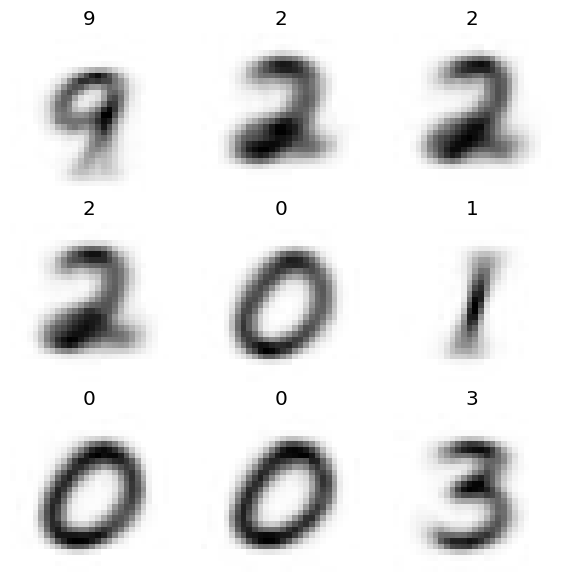

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 14.54 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.0004
Accuracy: 0.4339
Recall: 0.4266
F1-Score: 0.3501


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster04_v3.pkl')

Example 5

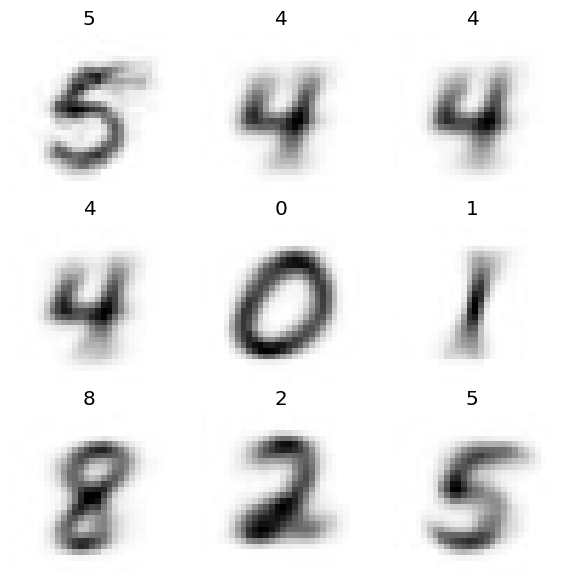

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.66 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.0899
Accuracy: 0.3661
Recall: 0.3597
F1-Score: 0.3101


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster05_v3.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

eXample 1

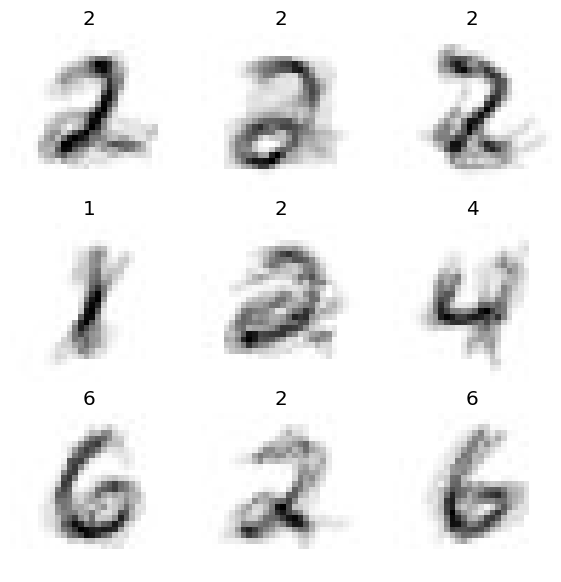

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 8663
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


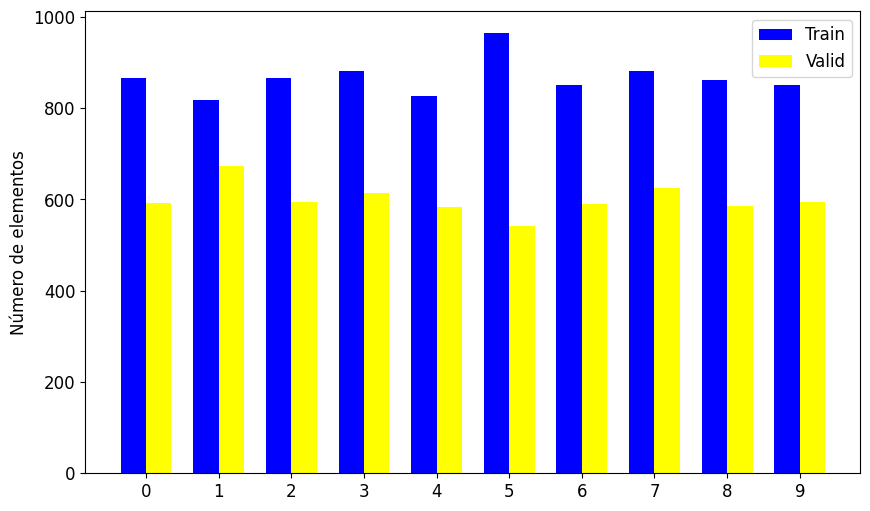

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 132.84 segundos


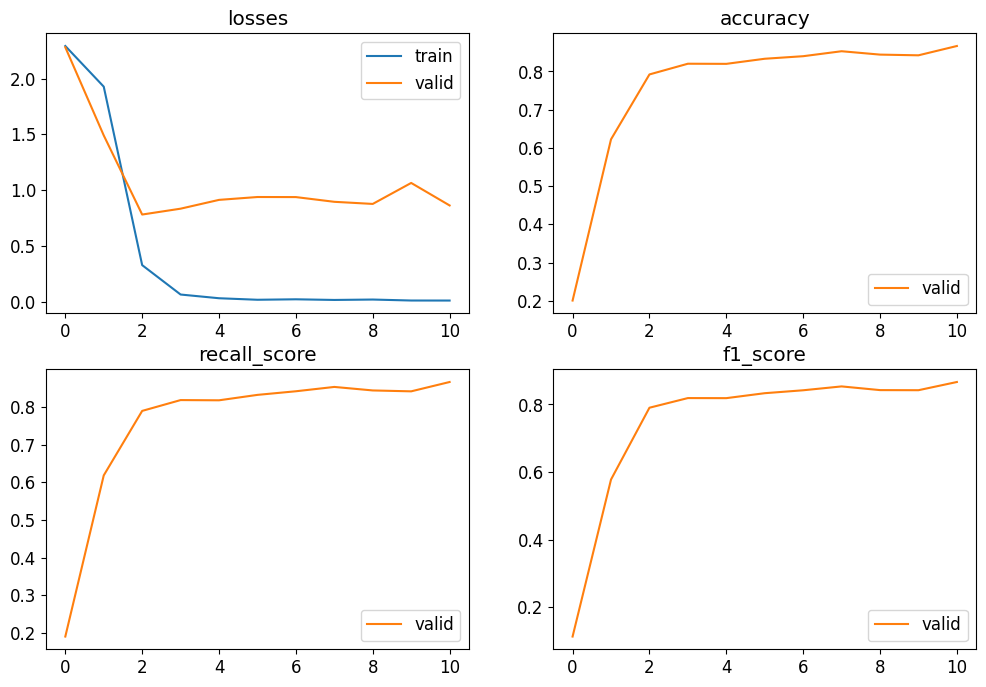

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8620
Accuracy: 0.8666
Recall: 0.8661
F1-Score: 0.8665


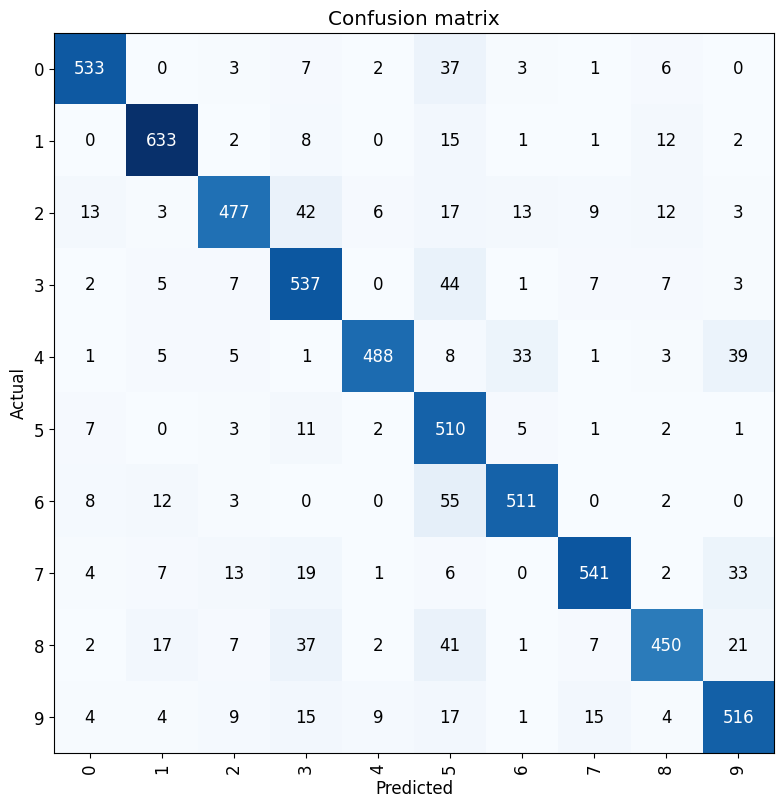

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v3.pkl')

Example 2

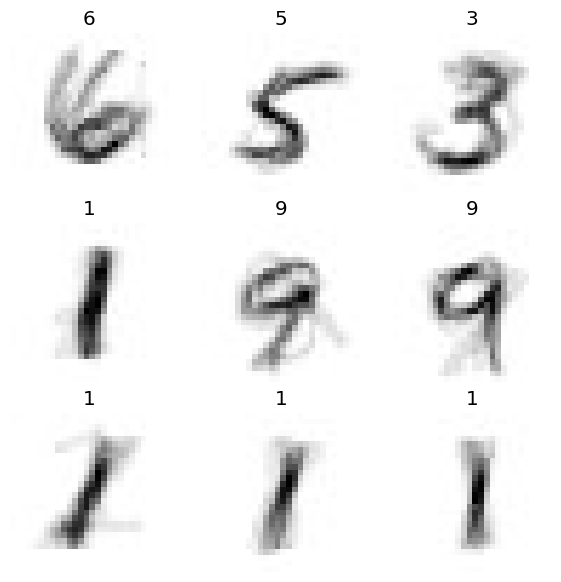

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 256.30 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2680
Accuracy: 0.8454
Recall: 0.8451
F1-Score: 0.8463


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v3.pkl')

example 3

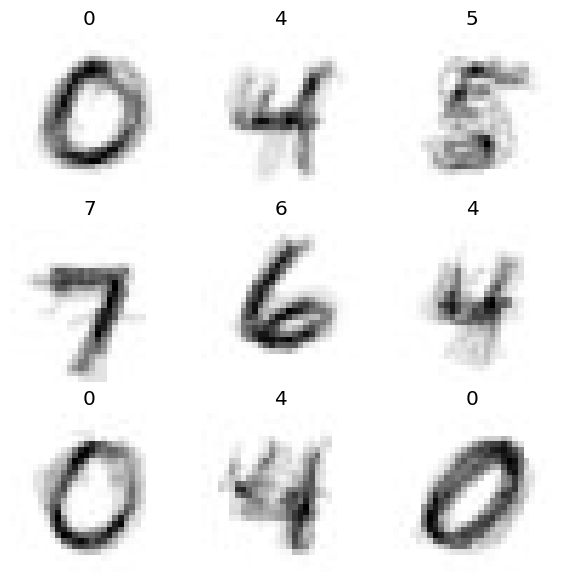

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 197.29 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2035
Accuracy: 0.8616
Recall: 0.8616
F1-Score: 0.8628


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v3.pkl')

Example 4

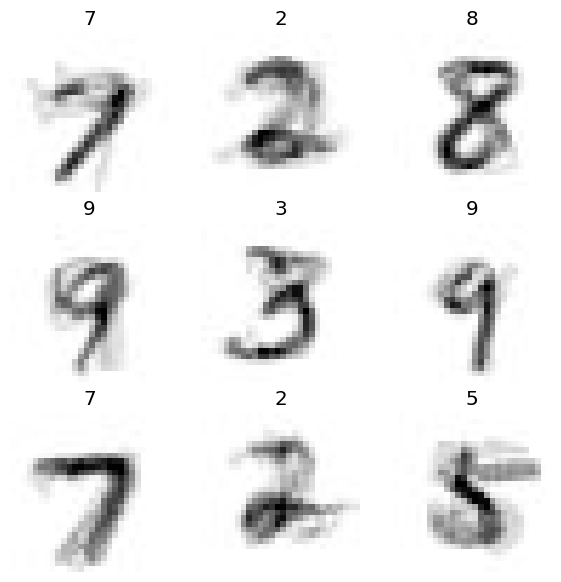

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 123.44 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1397
Accuracy: 0.8334
Recall: 0.8333
F1-Score: 0.8368


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster04_v3.pkl')

Example 5

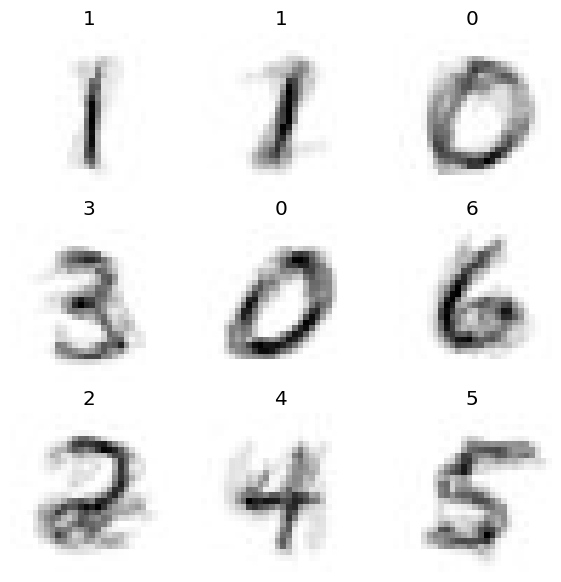

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 166.31 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9762
Accuracy: 0.8793
Recall: 0.8783
F1-Score: 0.8779


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster05_v3.pkl')

## Base - Resnet

Example 1

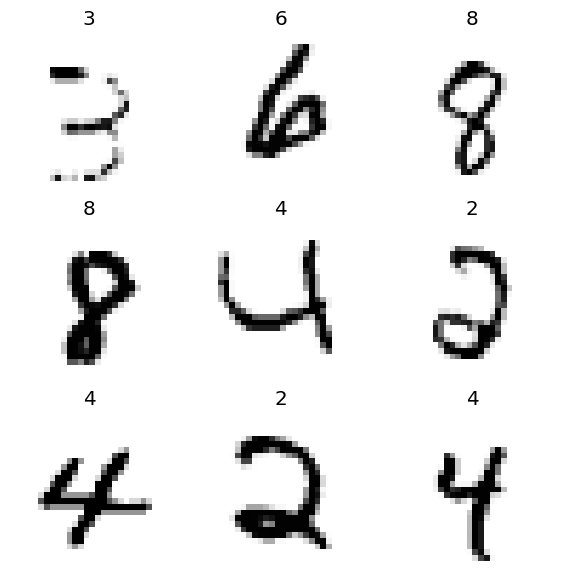

In [14]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [15]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 38368
Número total de imágenes en validación: 9592

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 3000.48 segundos


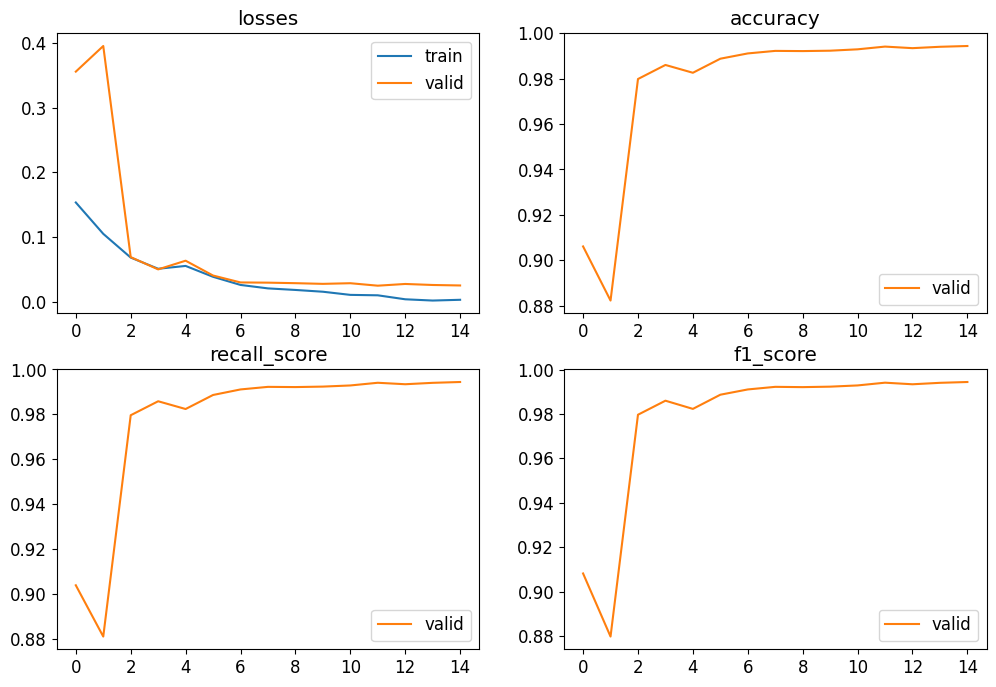

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0250
Accuracy: 0.9944
Recall: 0.9944
F1-Score: 0.9944


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_5cluster01_v3.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

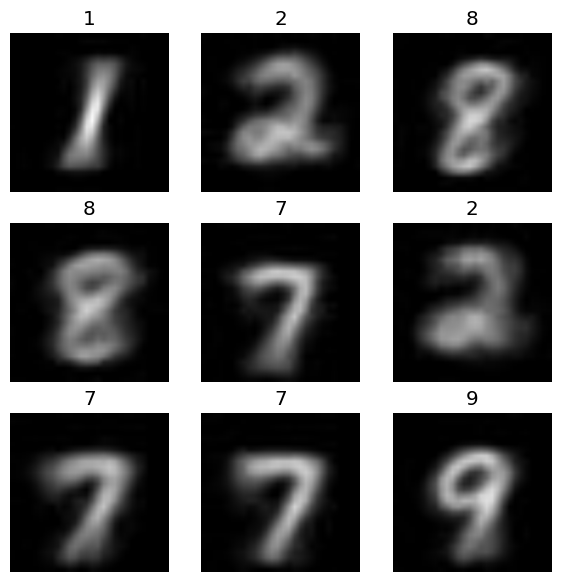

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 813
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 20.89 segundos


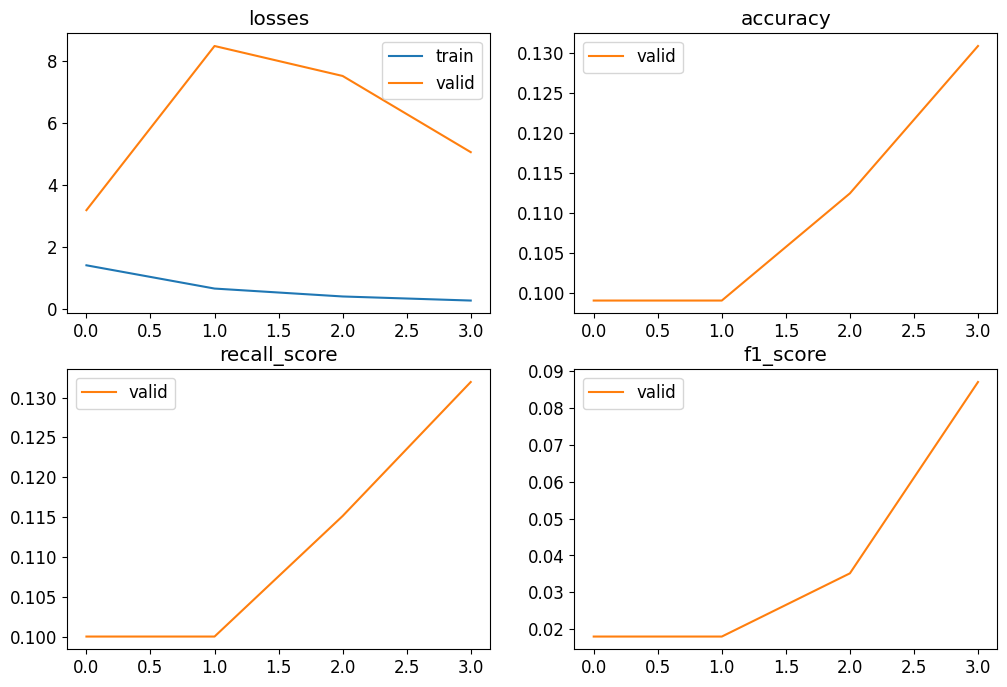

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 5.0578
Accuracy: 0.1309
Recall: 0.1319
F1-Score: 0.0870


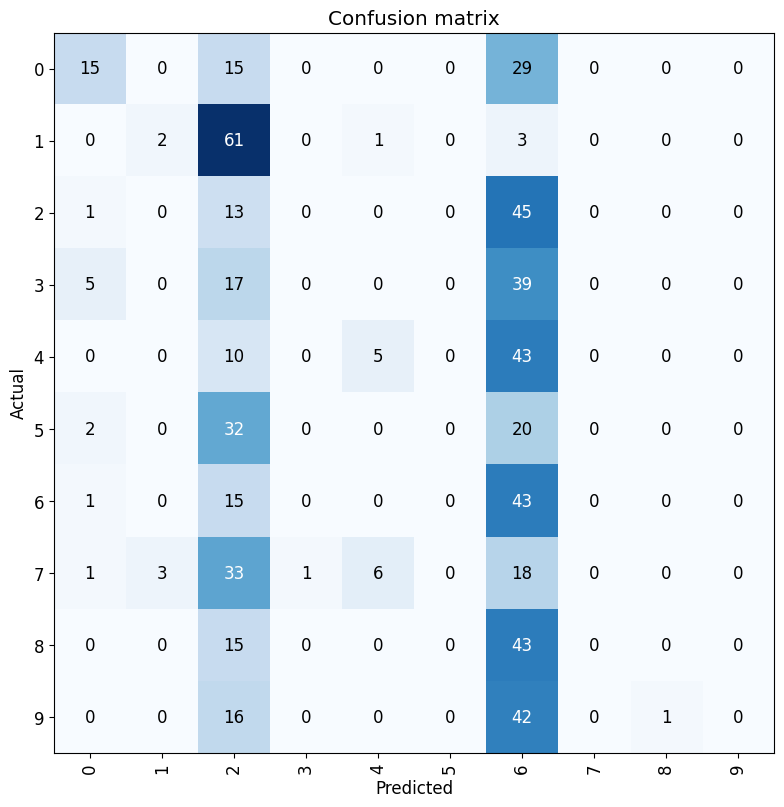

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v3.pkl')

Example 2

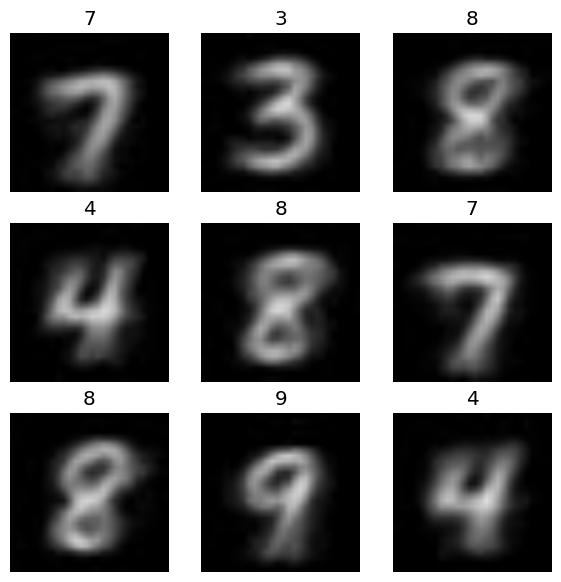

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 20.02 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 10.3698
Accuracy: 0.1594
Recall: 0.1547
F1-Score: 0.0993


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v3.pkl')

Example 3

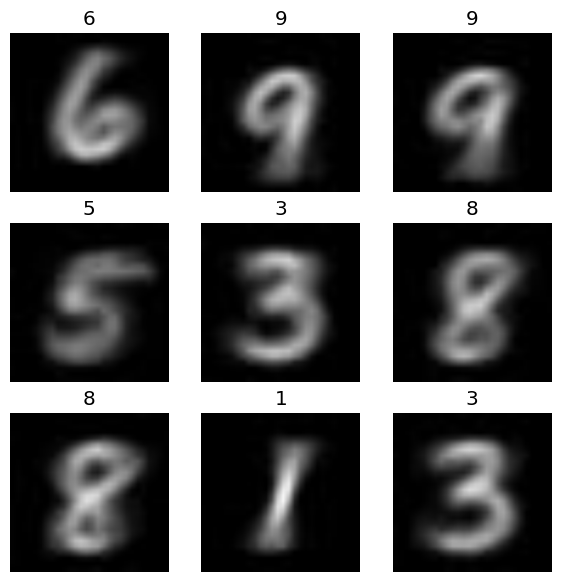

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 24.08 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.3541
Accuracy: 0.1292
Recall: 0.1341
F1-Score: 0.0930


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v3.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

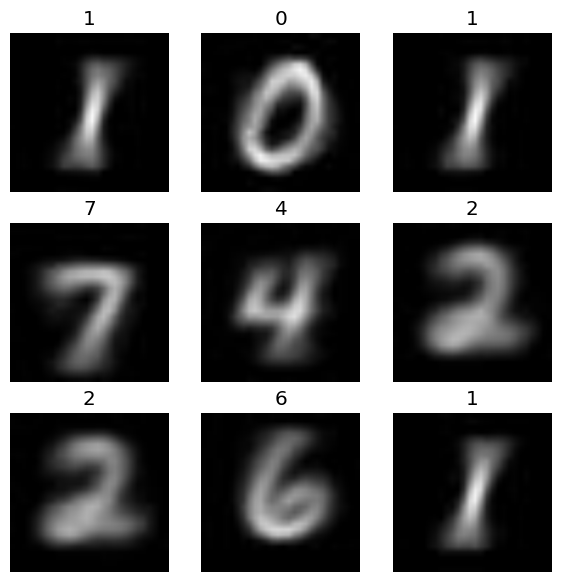

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 172
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 8.08 segundos


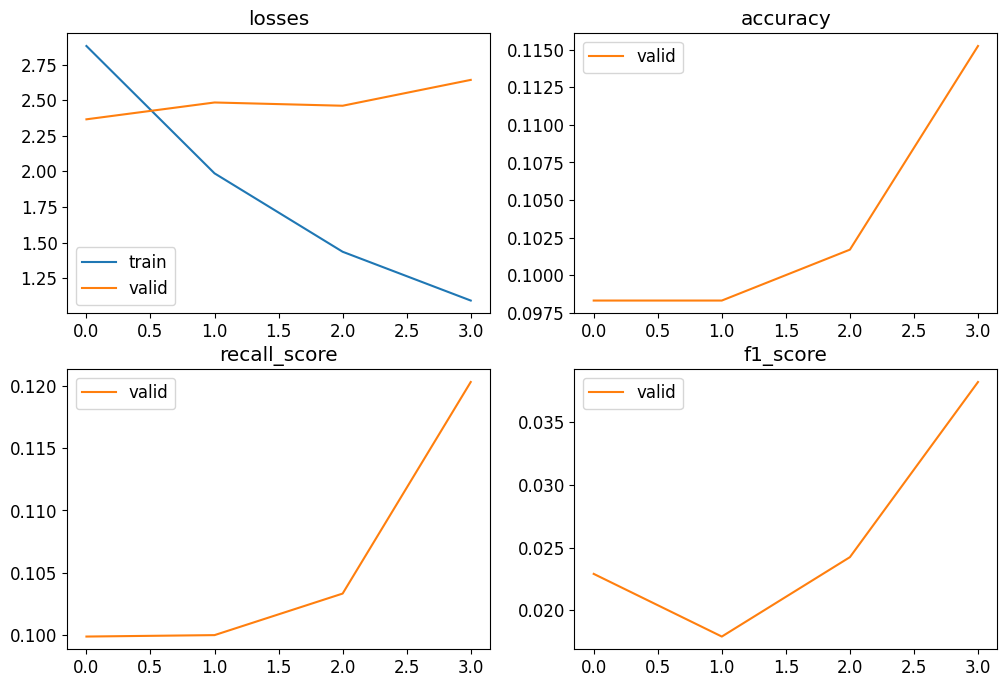

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.6420
Accuracy: 0.1153
Recall: 0.1203
F1-Score: 0.0382


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v3.pkl')

Example 2

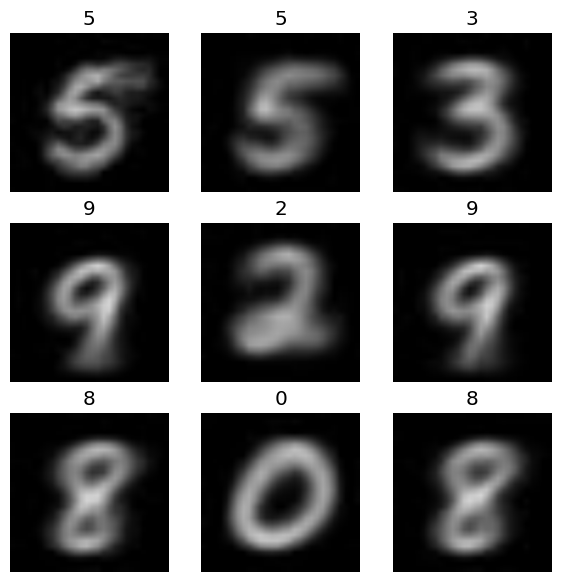

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 7.45 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.8926
Accuracy: 0.0780
Recall: 0.0834
F1-Score: 0.0357


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v3.pkl')

Example 3

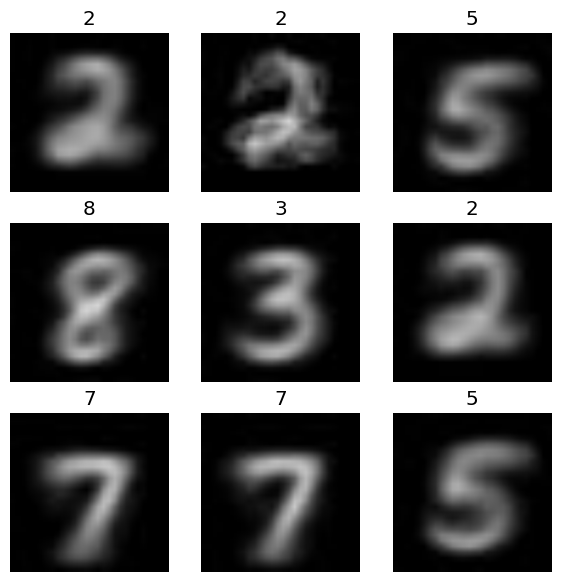

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 6.71 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.0698
Accuracy: 0.0915
Recall: 0.1000
F1-Score: 0.0168


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v3.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

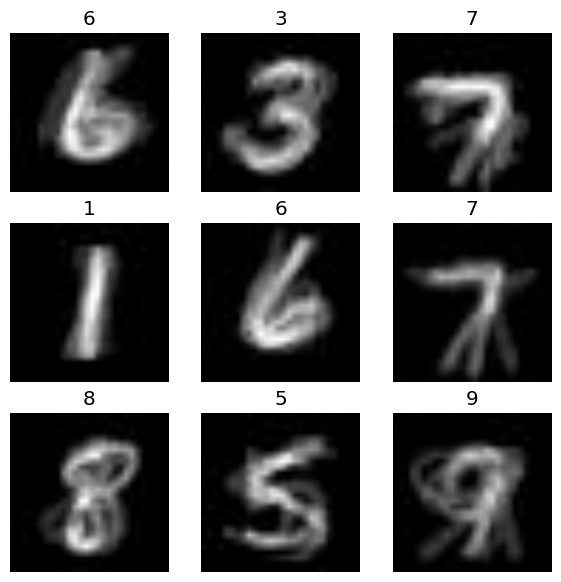

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 8694
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 25: early stopping

Tiempo de entrenamiento: 1553.88 segundos


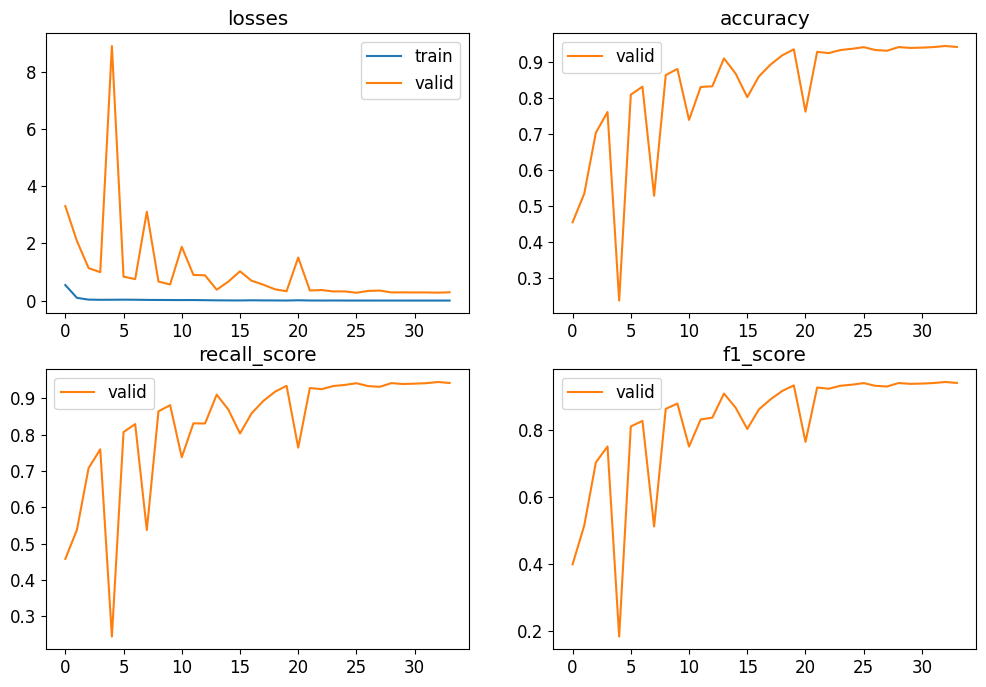

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2890
Accuracy: 0.9425
Recall: 0.9418
F1-Score: 0.9419


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v3.pkl')

Example 2

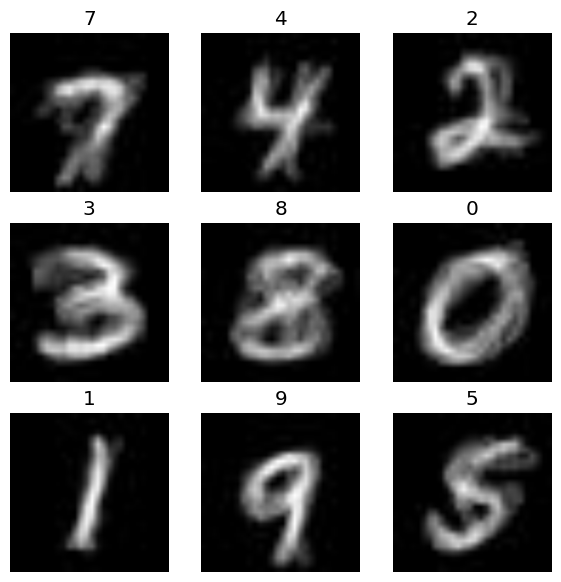

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 23: early stopping

Tiempo de entrenamiento: 1464.22 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4393
Accuracy: 0.9171
Recall: 0.9166
F1-Score: 0.9173


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v3.pkl')

Example 3

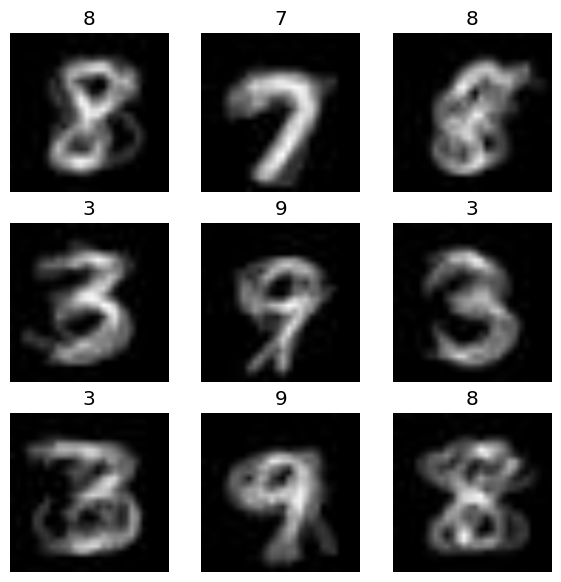

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 25: early stopping

Tiempo de entrenamiento: 1522.47 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3305
Accuracy: 0.9393
Recall: 0.9390
F1-Score: 0.9389


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v3.pkl')

Example 4

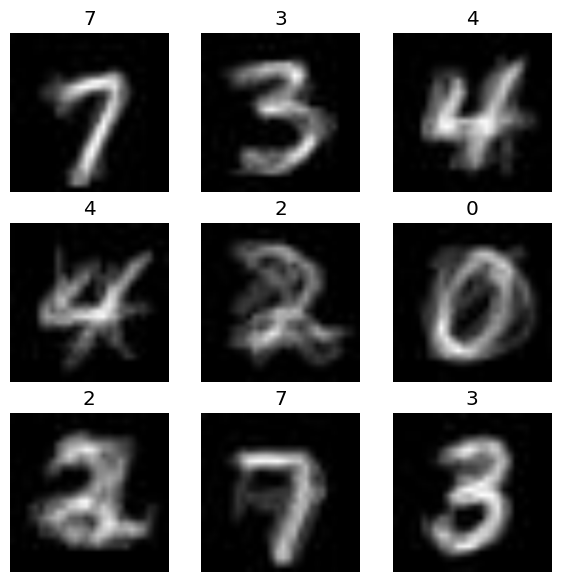

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 715.88 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7634
Accuracy: 0.8717
Recall: 0.8713
F1-Score: 0.8709


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster04_v3.pkl')

Example 5

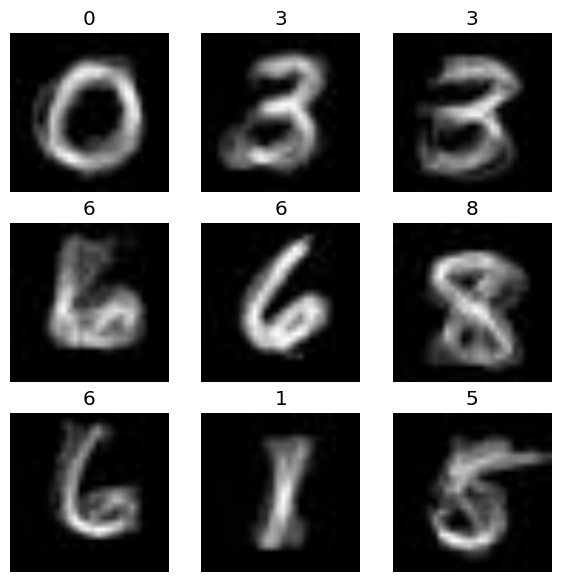

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 20: early stopping

Tiempo de entrenamiento: 1490.90 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.5182
Accuracy: 0.9129
Recall: 0.9127
F1-Score: 0.9126


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster05_v3.pkl')

# Apartado 4

## Base - Lenet

Example 1

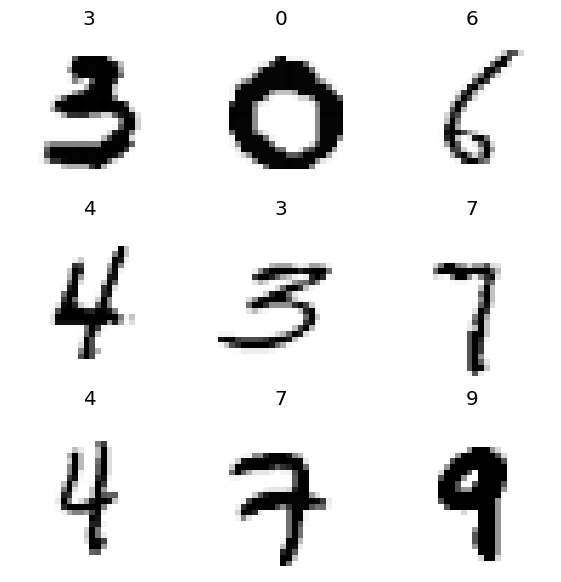

In [16]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 23852
Número total de imágenes en validación: 5963

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


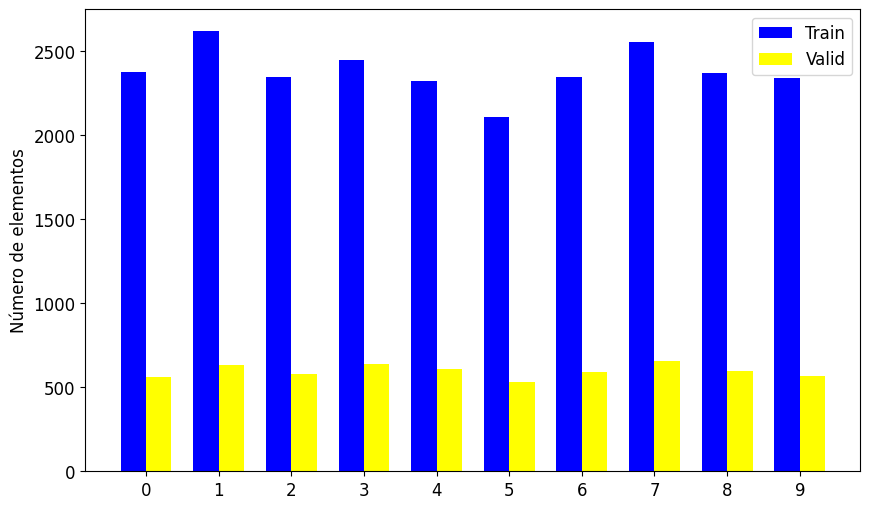

In [17]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 12: early stopping

Tiempo de entrenamiento: 466.98 segundos


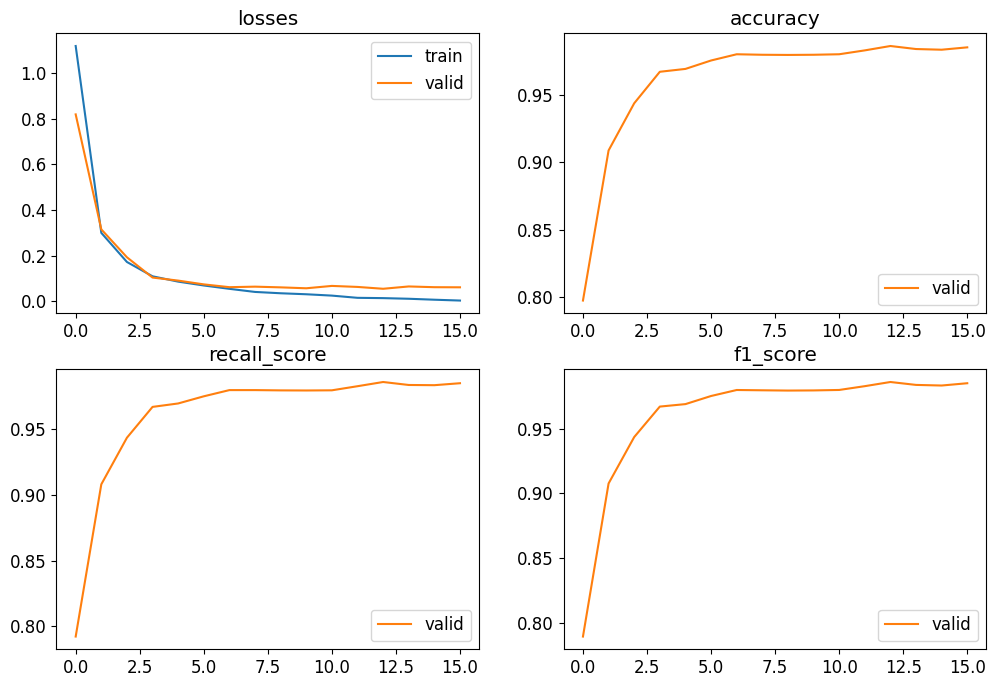

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0609
Accuracy: 0.9853
Recall: 0.9850
F1-Score: 0.9851


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_2cluster01_v3.pkl')

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

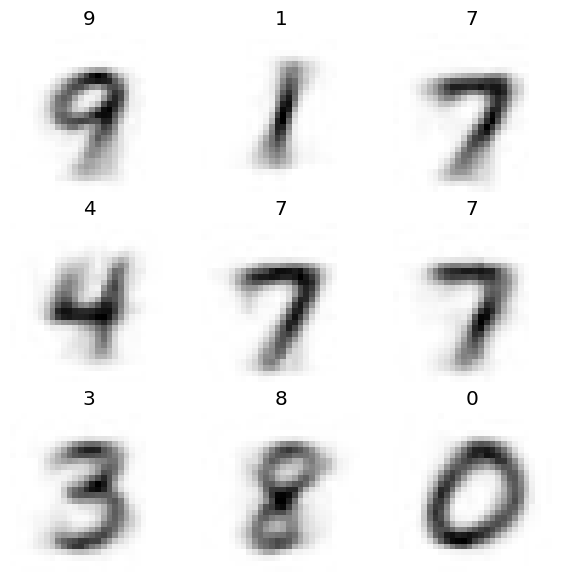

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 496
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


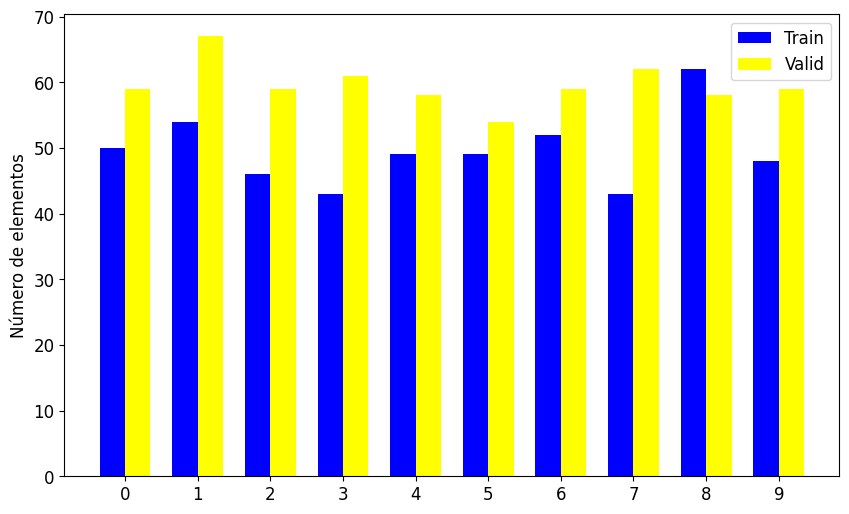

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 17.84 segundos


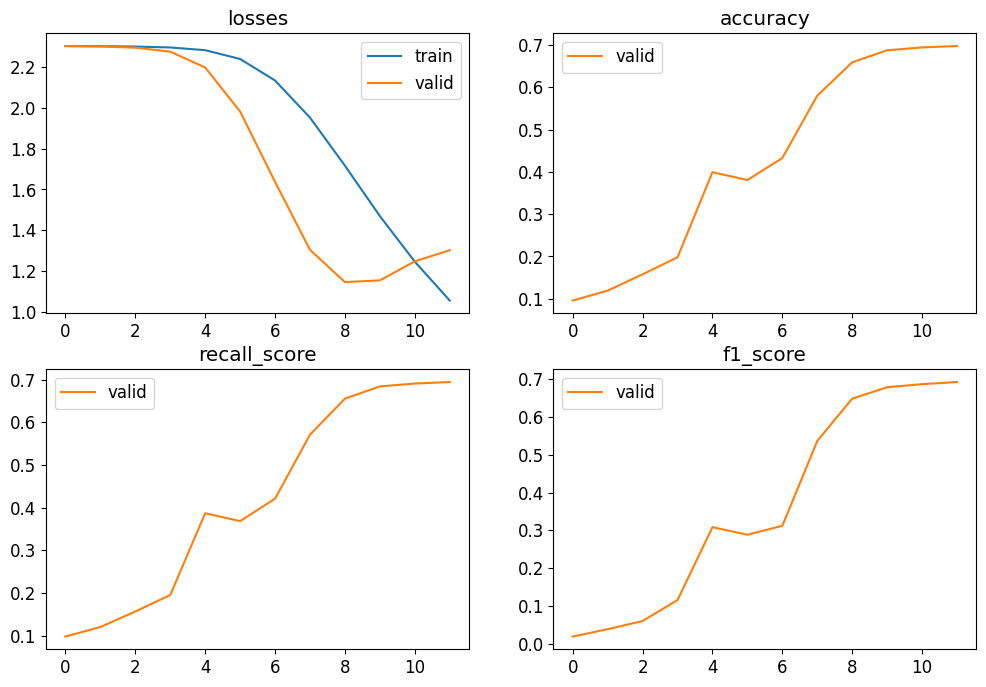

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3024
Accuracy: 0.6980
Recall: 0.6942
F1-Score: 0.6929


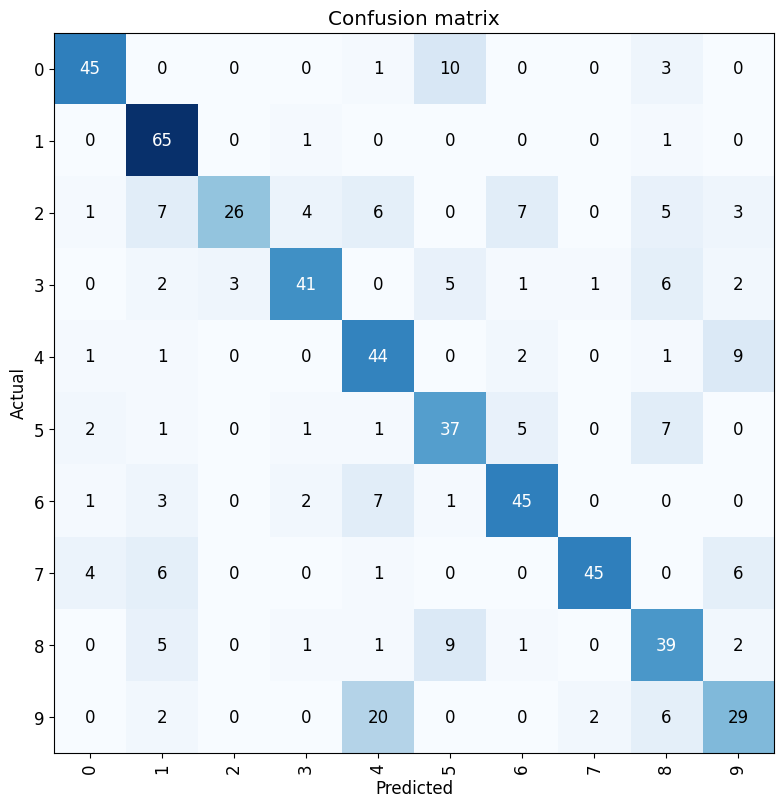

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster01_v3.pkl')

Example 2

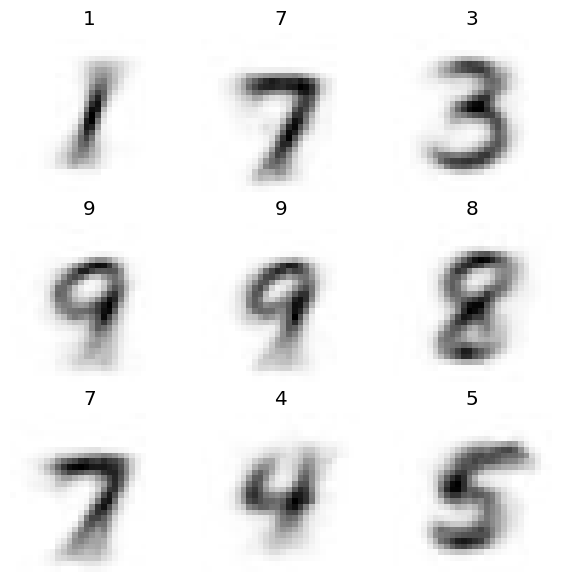

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 18.75 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.6095
Accuracy: 0.6309
Recall: 0.6270
F1-Score: 0.6241


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster02_v3.pkl')

Example 3

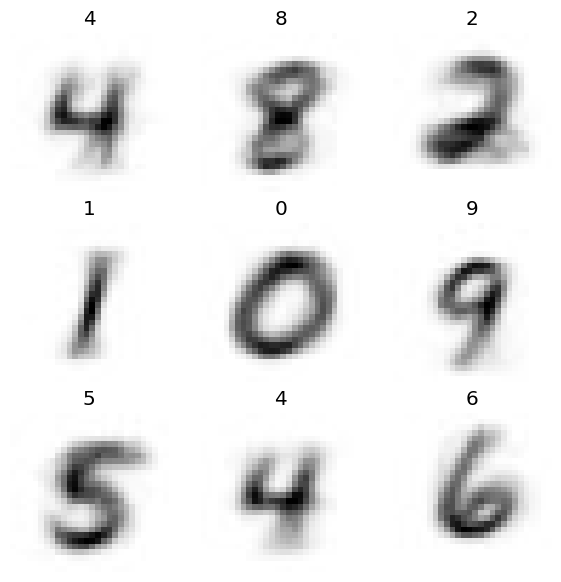

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 12.97 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3057
Accuracy: 0.7114
Recall: 0.7059
F1-Score: 0.7089


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster03_v3.pkl')

Example 4

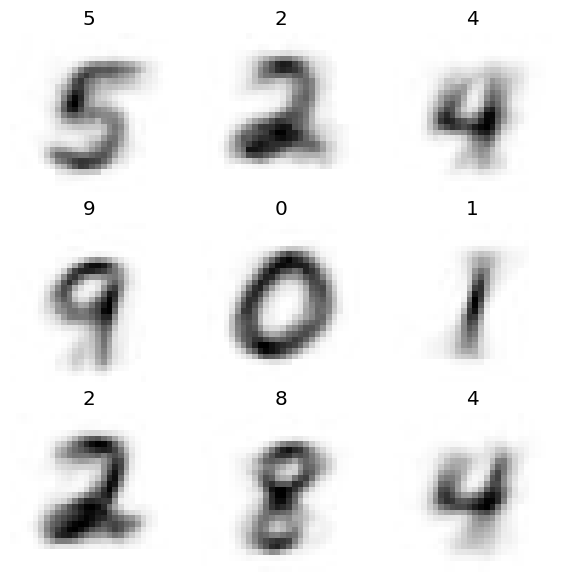

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 13.60 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3703
Accuracy: 0.6946
Recall: 0.6901
F1-Score: 0.6934


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster04_v3.pkl')

Example 5

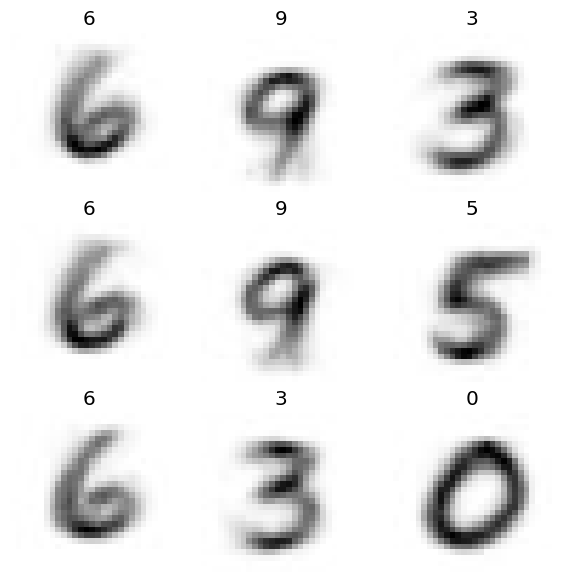

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 12.72 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2052
Accuracy: 0.7131
Recall: 0.7094
F1-Score: 0.7131


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster05_v3.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

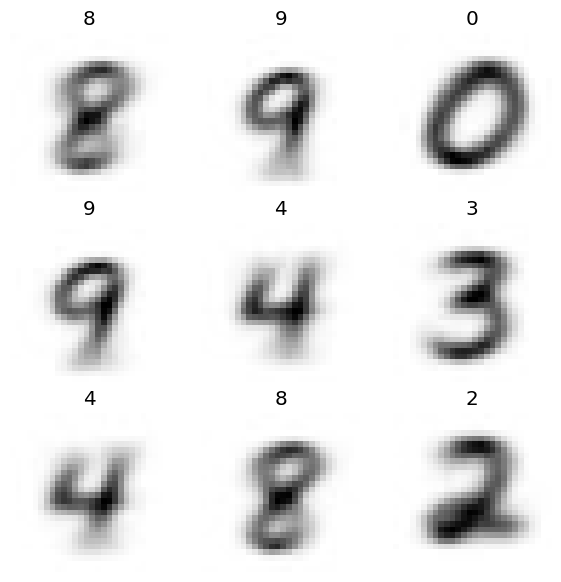

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 106
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


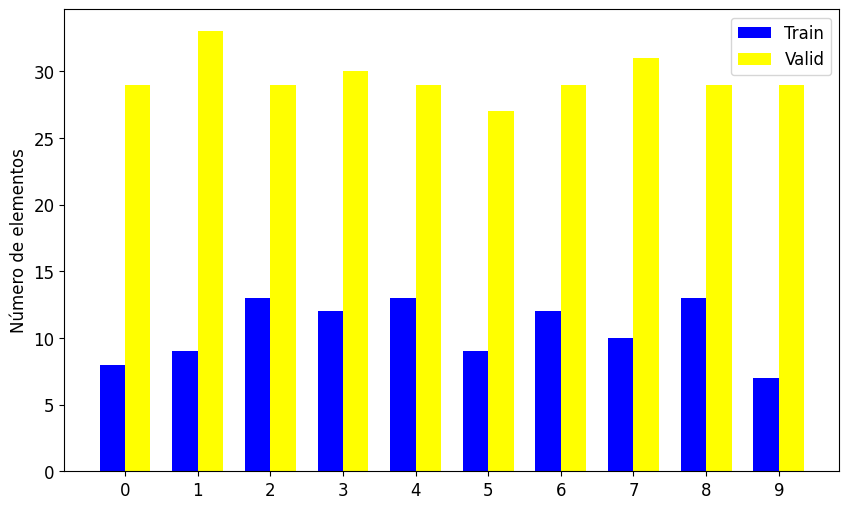

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.83 segundos


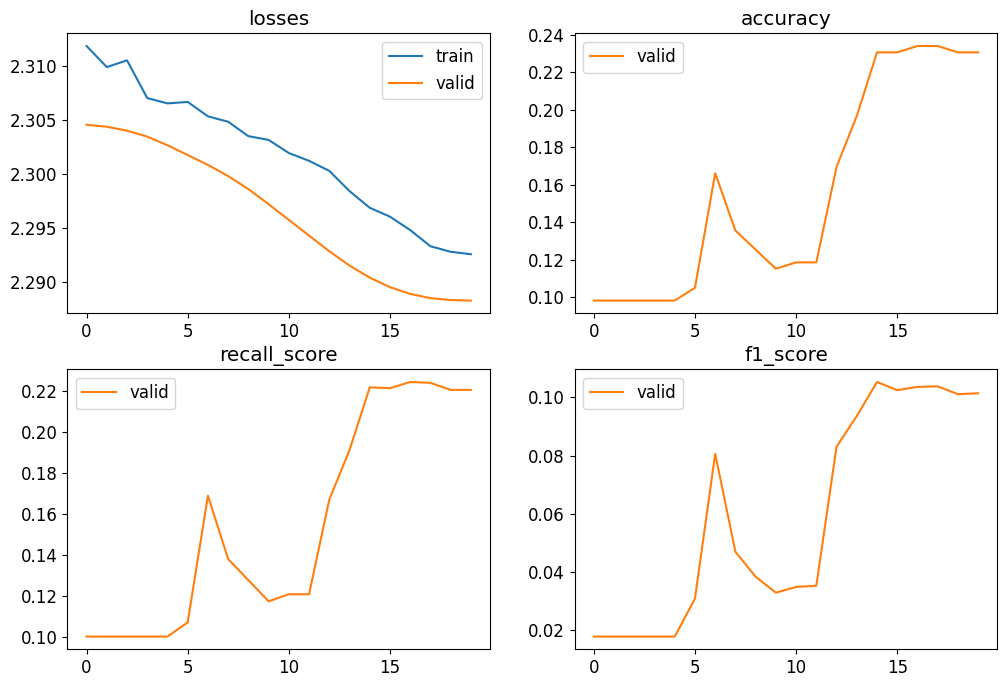

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2883
Accuracy: 0.2305
Recall: 0.2207
F1-Score: 0.1014


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster01_v3.pkl')

Example 2

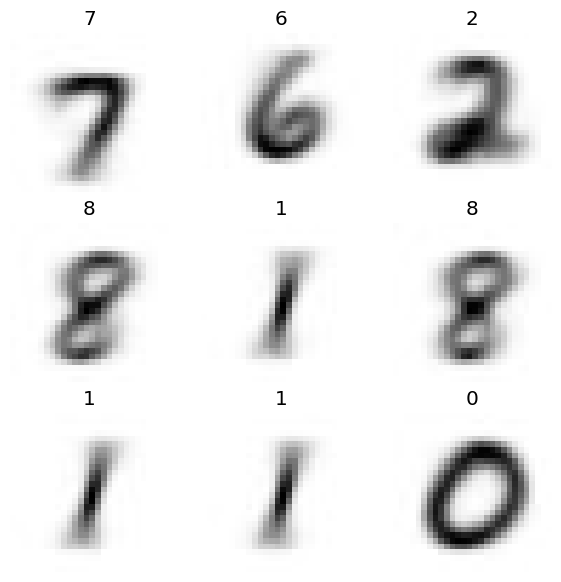

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 16.89 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2882
Accuracy: 0.2576
Recall: 0.2563
F1-Score: 0.1528


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster02_v3.pkl')

Example 3

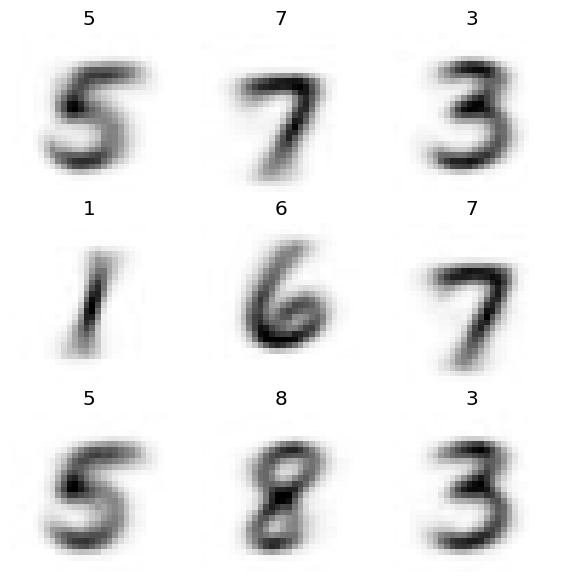

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.34 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2548
Accuracy: 0.2576
Recall: 0.2490
F1-Score: 0.1933


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster03_v3.pkl')

Example 4

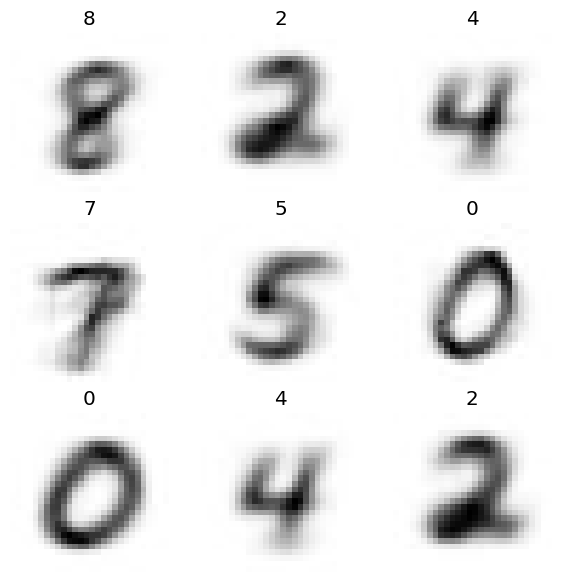

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.21 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2872
Accuracy: 0.0983
Recall: 0.1000
F1-Score: 0.0179


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster04_v3.pkl')

Example 5

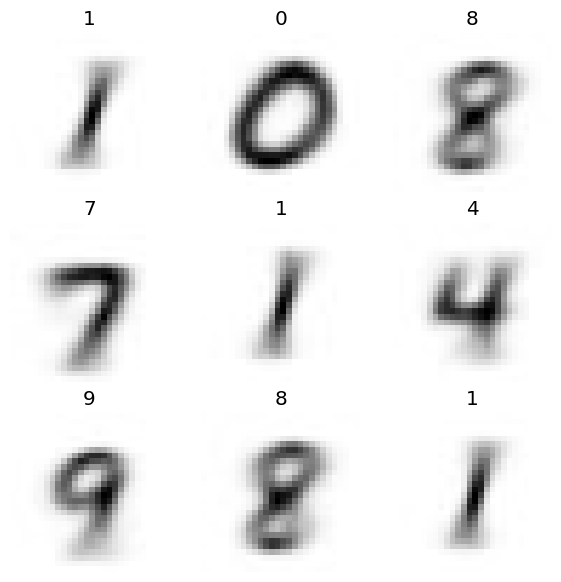

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.20 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2547
Accuracy: 0.3288
Recall: 0.3191
F1-Score: 0.1926


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster05_v3.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

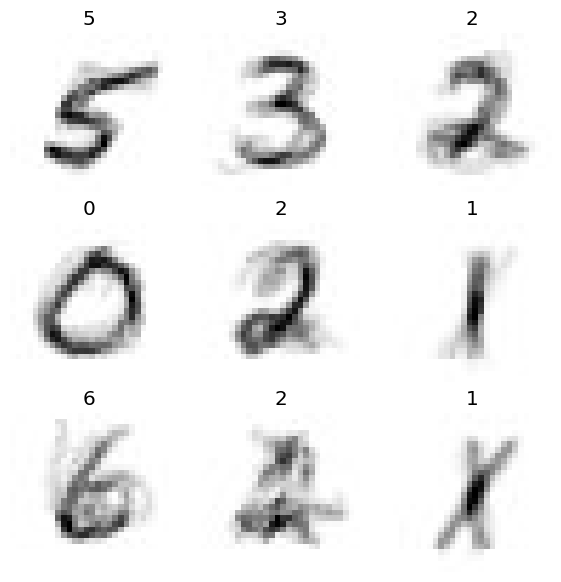

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 5501
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


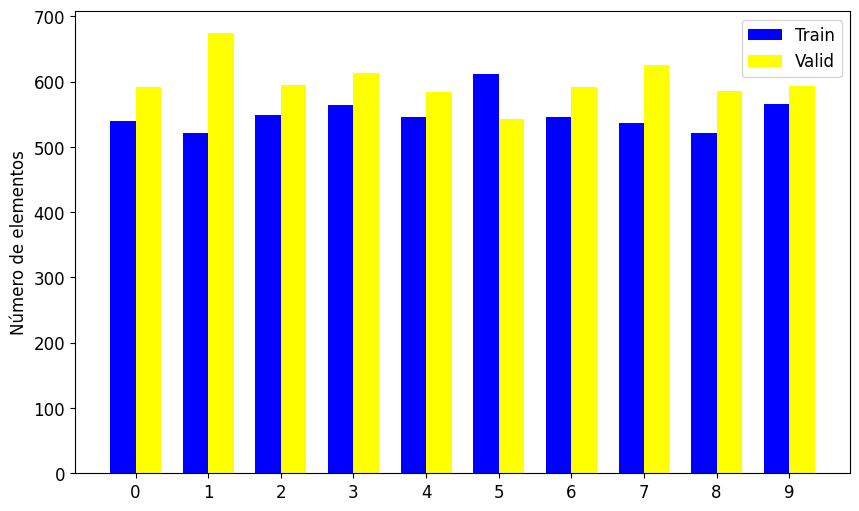

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 127.37 segundos


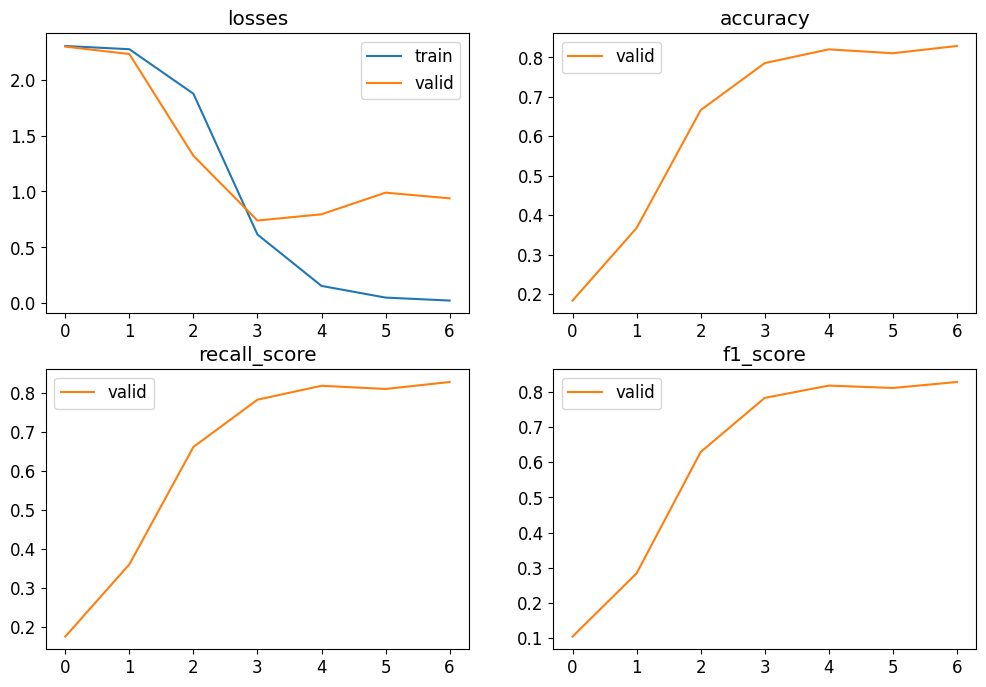

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9389
Accuracy: 0.8291
Recall: 0.8282
F1-Score: 0.8286


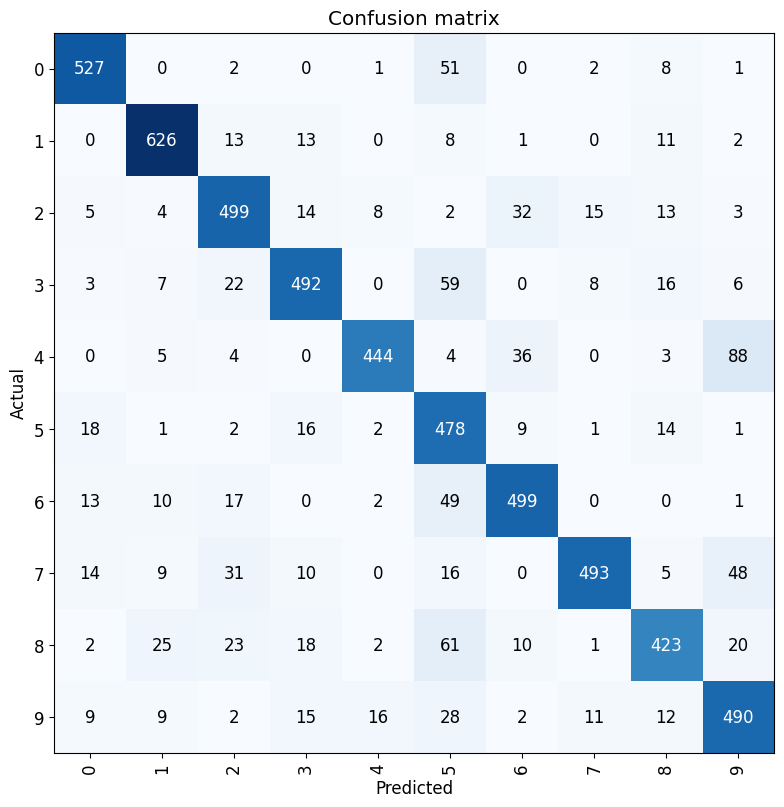

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster01_v3.pkl')

Exampel 2

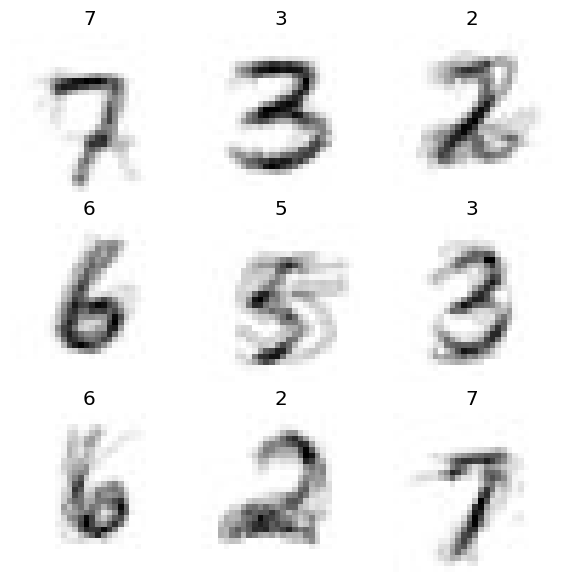

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 101.73 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9535
Accuracy: 0.8145
Recall: 0.8137
F1-Score: 0.8142


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v3.pkl')

Example 3

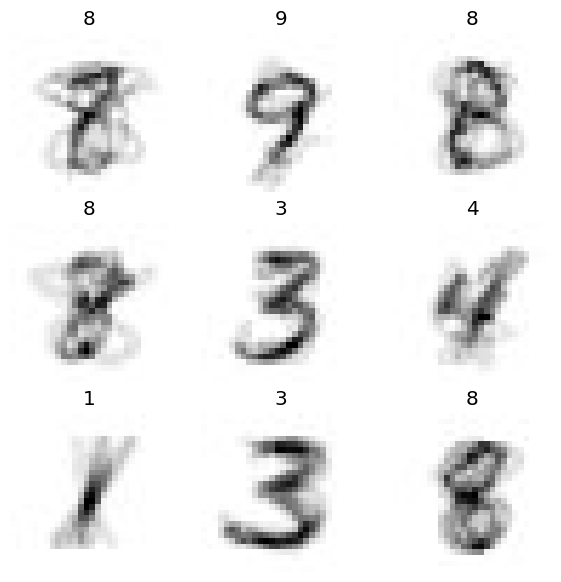

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 79.96 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.0932
Accuracy: 0.7922
Recall: 0.7916
F1-Score: 0.7896


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster03_v3.pkl')

Example 4

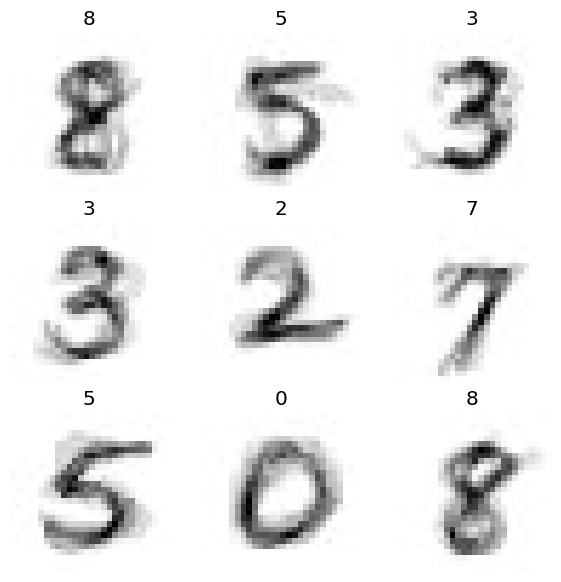

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 89.19 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.0280
Accuracy: 0.7962
Recall: 0.7950
F1-Score: 0.7910


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster04_v3.pkl')

Example 5

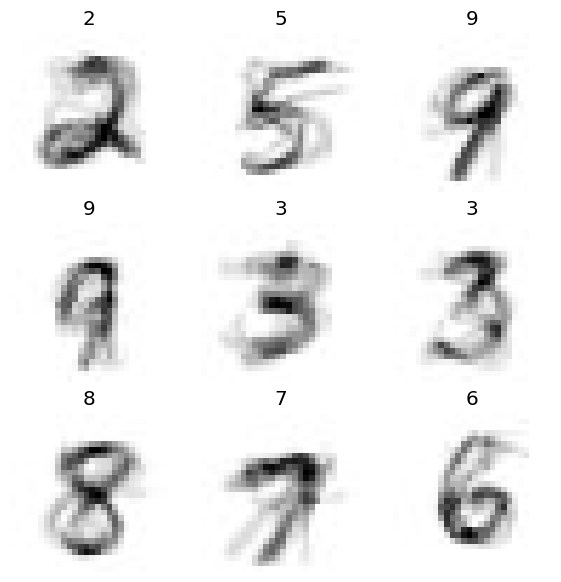

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 108.34 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9447
Accuracy: 0.8095
Recall: 0.8093
F1-Score: 0.8095


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster05_v3.pkl')

## Base - Resnet

Example 1

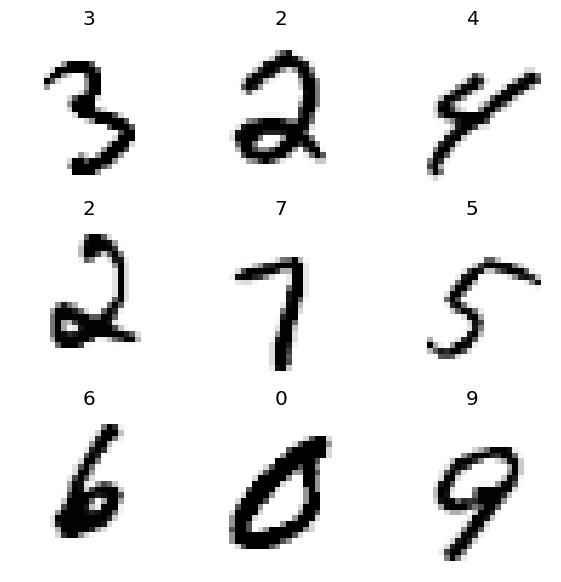

In [18]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [19]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 23878
Número total de imágenes en validación: 5969

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 2098.46 segundos


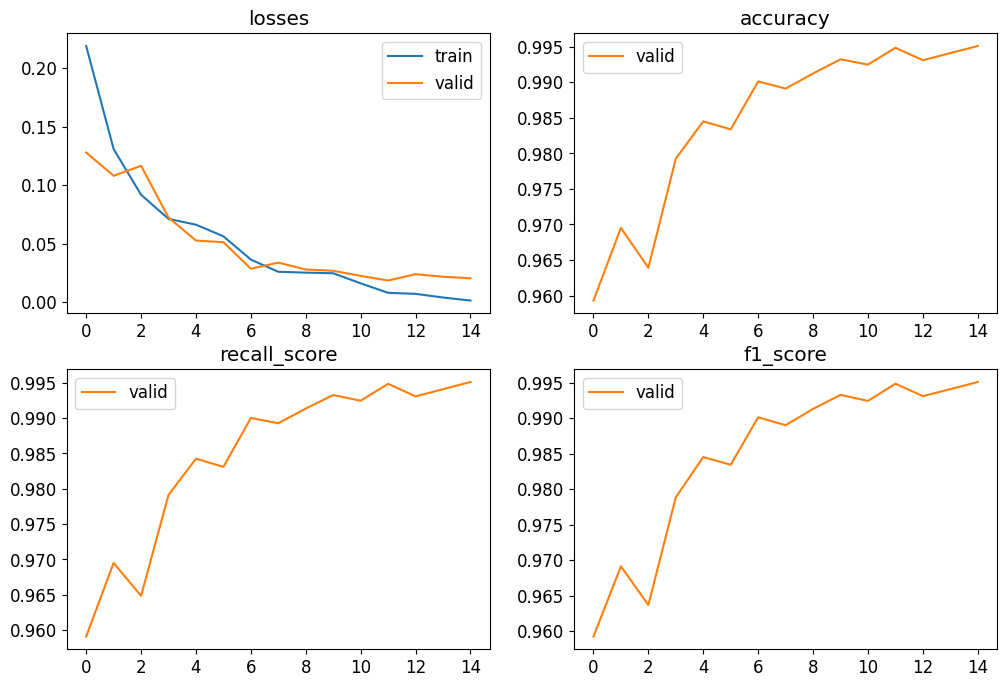

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0206
Accuracy: 0.9951
Recall: 0.9951
F1-Score: 0.9951


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_2cluster01_v3.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

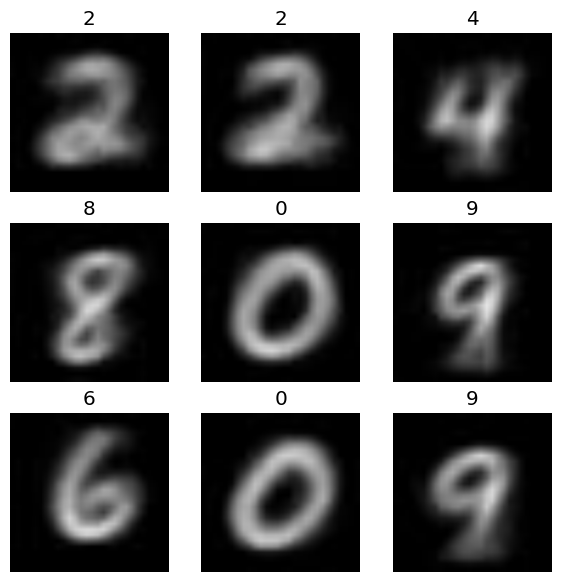

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 502
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 17.76 segundos


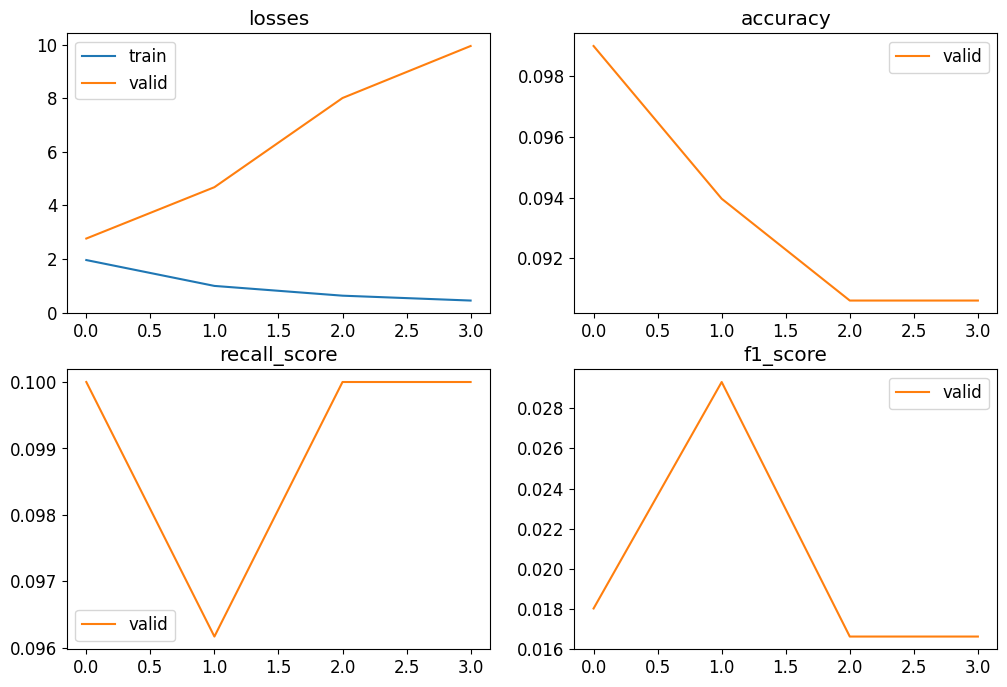

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 9.9477
Accuracy: 0.0906
Recall: 0.1000
F1-Score: 0.0166


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster01_v3.pkl')

Exaple 2

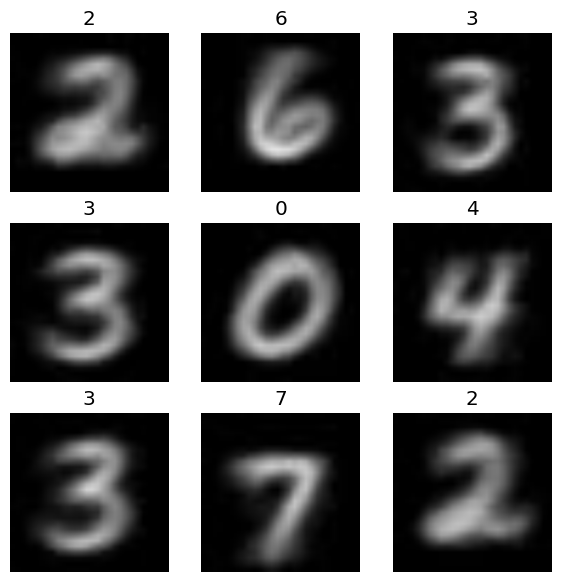

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 14.43 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 14.6313
Accuracy: 0.0906
Recall: 0.1000
F1-Score: 0.0166


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster02_v3.pkl')

Example 3

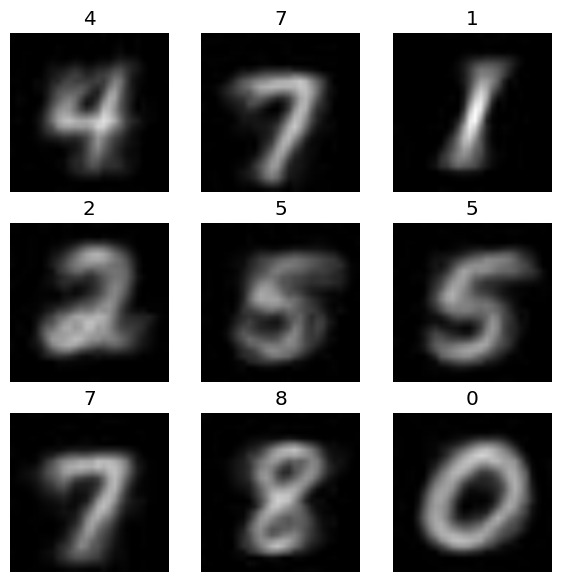

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 14.40 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 11.6779
Accuracy: 0.0906
Recall: 0.1000
F1-Score: 0.0166


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster03_v3.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

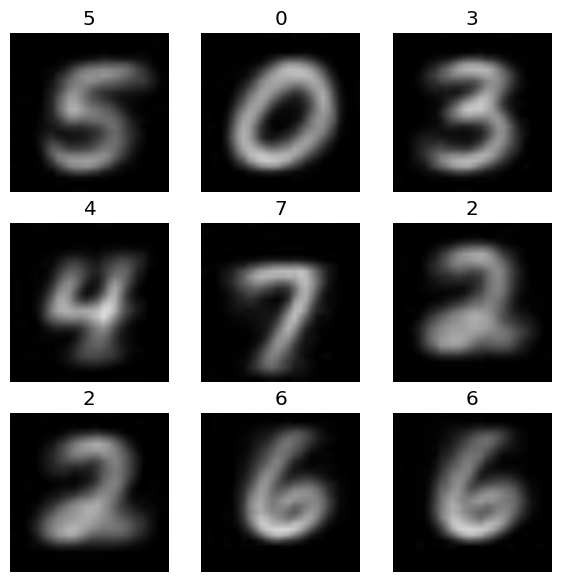

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 104
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 5.14 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.6361
Accuracy: 0.1085
Recall: 0.1134
F1-Score: 0.0422


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster01_v3.pkl')

Example 2

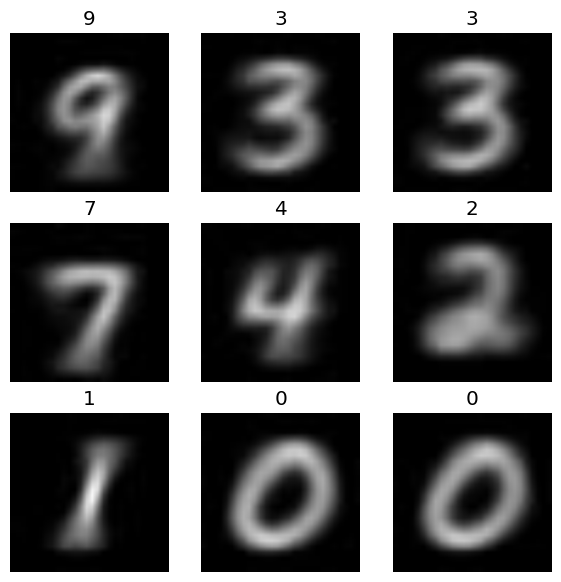

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 5.47 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.5601
Accuracy: 0.0949
Recall: 0.1034
F1-Score: 0.0222


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster02_v3.pkl')

Example 3

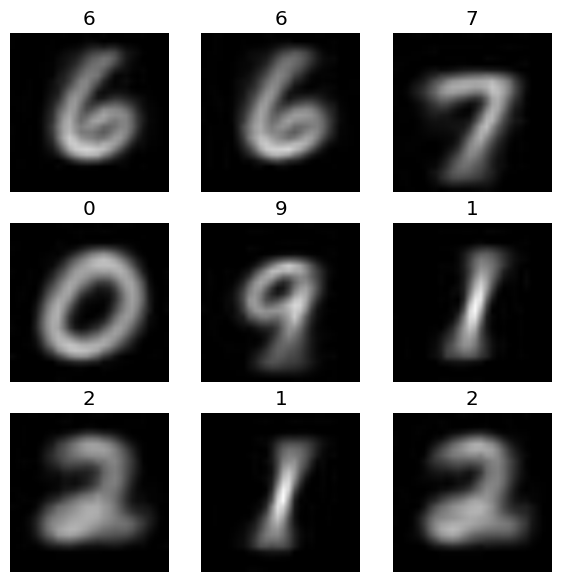

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 8.63 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.3713
Accuracy: 0.0915
Recall: 0.1000
F1-Score: 0.0168


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster03_v3.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

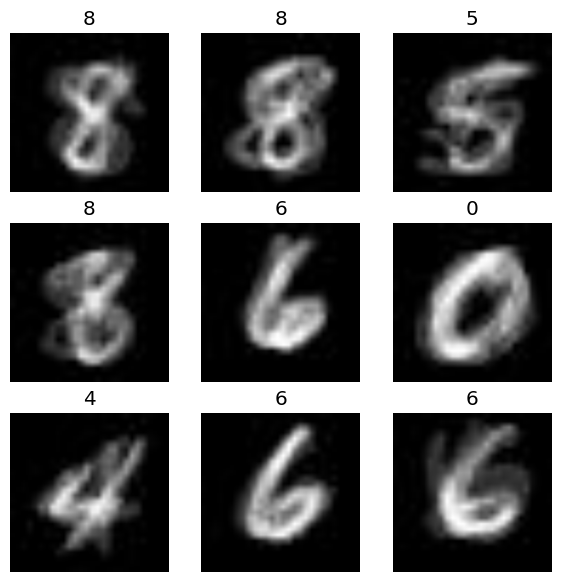

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 5441
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 23: early stopping

Tiempo de entrenamiento: 1052.12 segundos


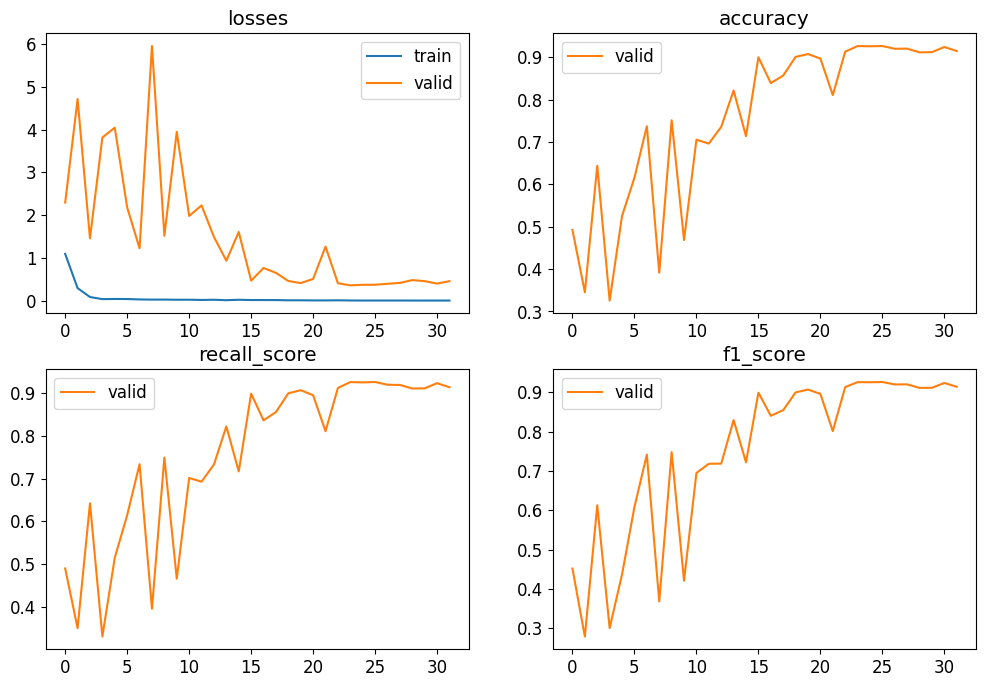

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4535
Accuracy: 0.9146
Recall: 0.9145
F1-Score: 0.9141


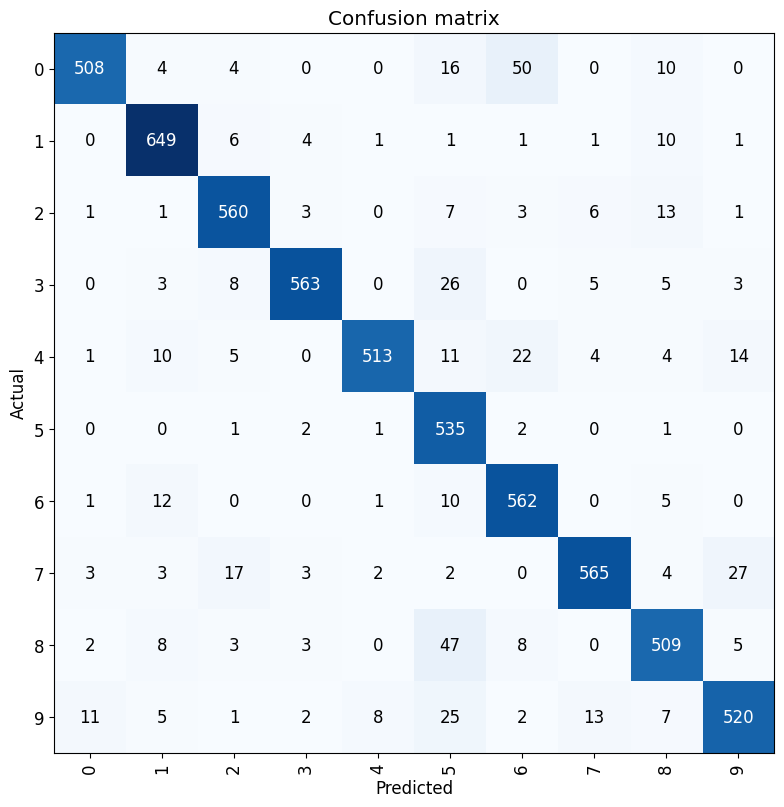

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster01_v3.pkl')

Example 2

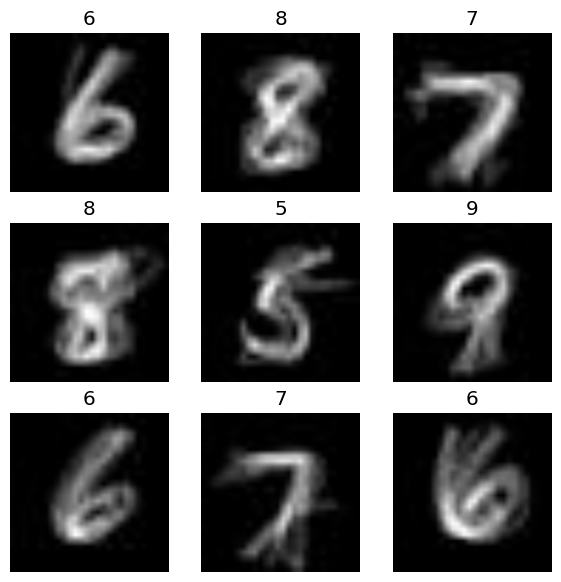

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 479.26 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9900
Accuracy: 0.8079
Recall: 0.8063
F1-Score: 0.8055


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster02_v3.pkl')

Example 3

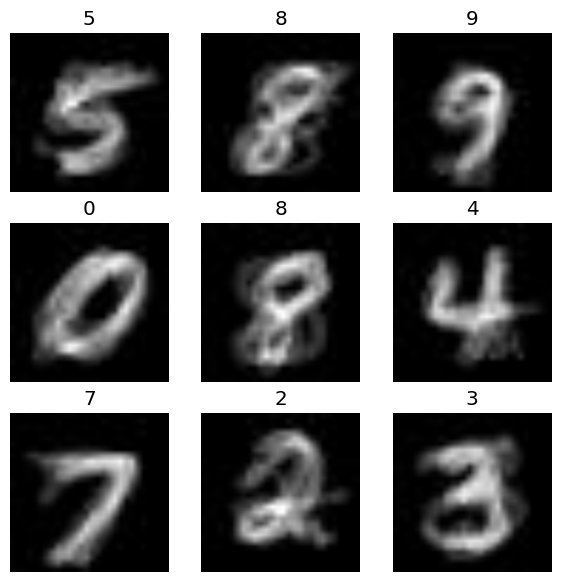

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 17: early stopping

Tiempo de entrenamiento: 831.42 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3471
Accuracy: 0.9281
Recall: 0.9277
F1-Score: 0.9273


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster03_v3.pkl')

Example 04

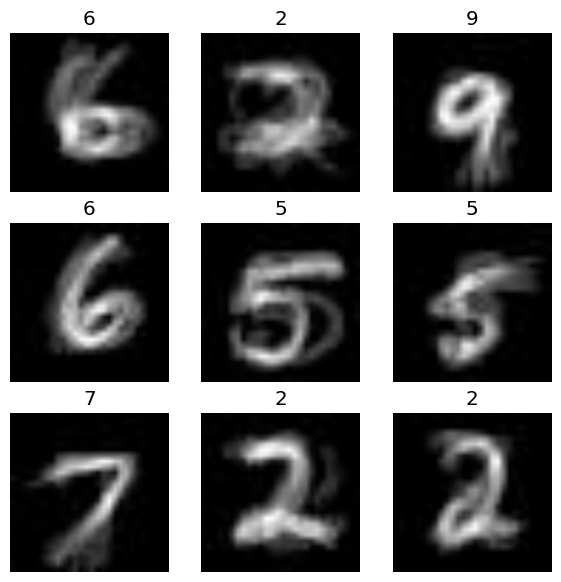

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 29: early stopping

Tiempo de entrenamiento: 1229.25 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4275
Accuracy: 0.9169
Recall: 0.9168
F1-Score: 0.9171


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster04_v3.pkl')

Example 05

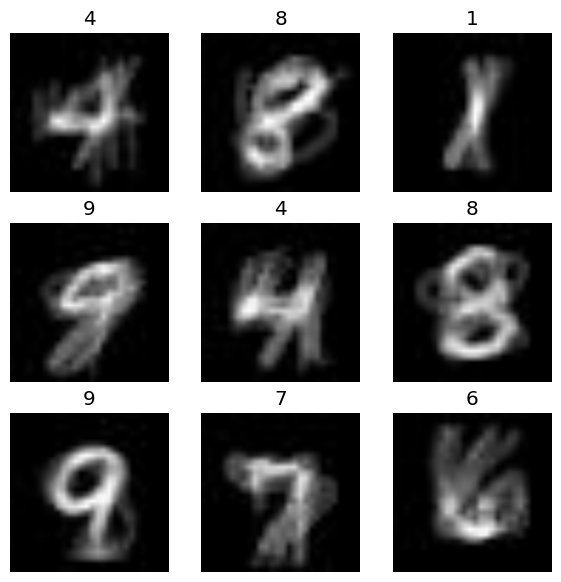

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 22: early stopping

Tiempo de entrenamiento: 998.95 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4163
Accuracy: 0.9141
Recall: 0.9134
F1-Score: 0.9132


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster05_v3.pkl')

# TEST

In [ ]:
test_path = Path('/content/dataset/original/mnist_png/testing')

## Original - Lenet

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)


In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.03486732020974159
Accuracy: 0.9899839758872986
Recall (macro): 0.9898853968743563
F1 Score (macro): 0.9899635312113005


## Original - RESNET18

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    #splitter=IndexSplitter([])
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)


In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.0206071175634861
Accuracy: 0.9947916865348816
Recall (macro): 0.994705931233183
F1 Score (macro): 0.994726425556588


## Distilled 001 - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.3649392127990723
Accuracy: 0.7341746687889099
Recall (macro): 0.7299624559966862
F1 Score (macro): 0.7301668552950961


## Distilled 005 - Lenet

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9974194765090942
Accuracy: 0.7400841116905212
Recall (macro): 0.7377306101936207
F1 Score (macro): 0.7398467102538248


## Distilled 0001 - Lenet

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9439882040023804
Accuracy: 0.8557692170143127
Recall (macro): 0.854324120644605
F1 Score (macro): 0.8541724914528028


## Distilled 001 - Resnet18

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_v3.pkl')
#learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 30.122392654418945
Accuracy: 0.10737179219722748
Recall (macro): 0.11173037049958141
F1 Score (macro): 0.03833584166674263


## Dsitilled 05 - Resnet18

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_v3.pkl')
#learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.820537090301514
Accuracy: 0.09034454822540283
Recall (macro): 0.10095378384954982
F1 Score (macro): 0.018478644304440826


## Distilled 0001 - Resnet18

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_v3.pkl')
#learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.3051925003528595
Accuracy: 0.9426081776618958
Recall (macro): 0.9423554878739125
F1 Score (macro): 0.9418279604399876


## Base & 5 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.006254005711525679
Accuracy: 0.9985977411270142
Recall (macro): 0.9985736462027214
F1 Score (macro): 0.9985879757982946


## Distilled 001 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.8412331938743591
Accuracy: 0.8408453464508057
Recall (macro): 0.8395169919069996
F1 Score (macro): 0.8395412997091084


 Distilled 001 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.6296316385269165
Accuracy: 0.6921073794364929
Recall (macro): 0.6877145995930078
F1 Score (macro): 0.6870891636103051


Distilled 001 & 5 cluster - Lenet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9248610138893127
Accuracy: 0.8093950152397156
Recall (macro): 0.8063082389316218
F1 Score (macro): 0.8069319455741493


Distilled 001 & 5 cluster - Lenet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.4133340120315552
Accuracy: 0.7244591116905212
Recall (macro): 0.721416051748142
F1 Score (macro): 0.7221294854683119


Distilled 001 & 5 cluster - Lenet Ex5


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.2319222688674927
Accuracy: 0.7381811141967773
Recall (macro): 0.7339243738471298
F1 Score (macro): 0.7343782104696792


## Distilled 005 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.1622562408447266
Accuracy: 0.3902243673801422
Recall (macro): 0.3735836137901628
F1 Score (macro): 0.29090012821552286


Distilled 005 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.163581132888794
Accuracy: 0.48317307233810425
Recall (macro): 0.4758340474361368
F1 Score (macro): 0.3927332525099173


Distilled 005 & 5 cluster - Lenet Ex3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.0692710876464844
Accuracy: 0.5830328464508057
Recall (macro): 0.5679390504669213
F1 Score (macro): 0.5226640688878109


Distilled 005 & 5 cluster - Lenet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.986890196800232
Accuracy: 0.4520232379436493
Recall (macro): 0.44686544752194435
F1 Score (macro): 0.362263944790597


Distilled 005 & 5 cluster - Lenet Ex5


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.083204507827759
Accuracy: 0.38161057233810425
Recall (macro): 0.3762646469742077
F1 Score (macro): 0.31943177395407946


## Distilled 0001 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.7638741135597229
Accuracy: 0.8805088400840759
Recall (macro): 0.8801501753300542
F1 Score (macro): 0.8796120534886189


Distilled 0001 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.148859977722168
Accuracy: 0.8679887652397156
Recall (macro): 0.8677382003128342
F1 Score (macro): 0.8669261394581117


Distilled 0001 & 5 cluster - Lenet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.0816015005111694
Accuracy: 0.871995210647583
Recall (macro): 0.8721866112367364
F1 Score (macro): 0.8720933907519253


Distilled 0001 & 5 cluster - Lenet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.0113917589187622
Accuracy: 0.8516626358032227
Recall (macro): 0.8517531498007864
F1 Score (macro): 0.8528063488260628


Distilled 0001 & 5 cluster - Lenet Ex5


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9227574467658997
Accuracy: 0.885817289352417
Recall (macro): 0.8850303891879058
F1 Score (macro): 0.8840881905910523


## Base & 5 cluster - Resnet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_5cluster01_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.0019627048168331385
Accuracy: 0.9992988705635071
Recall (macro): 0.9993018145459882
F1 Score (macro): 0.9993065999806581


## Distilled 001 & 5 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.91459321975708
Accuracy: 0.13511618971824646
Recall (macro): 0.13785626421035255
F1 Score (macro): 0.08938401063361207


 Distilled 001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 10.52920913696289
Accuracy: 0.15815304219722748
Recall (macro): 0.15656745324088872
F1 Score (macro): 0.10164553686576287


 Distilled 001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.237741947174072
Accuracy: 0.14372996985912323
Recall (macro): 0.14923061592274822
F1 Score (macro): 0.11291330835628657


## Distilled 005 & 5 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.635329484939575
Accuracy: 0.10096153616905212
Recall (macro): 0.10215834386542437
F1 Score (macro): 0.032234225883989755


Distilled 005 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.897846221923828
Accuracy: 0.08112980425357819
Recall (macro): 0.08872584896190777
F1 Score (macro): 0.031944699466864394


Distilled 005 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.073541164398193
Accuracy: 0.08924278616905212
Recall (macro): 0.1
F1 Score (macro): 0.016386206896551726


## Distilled 0001 & 5 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.23194622993469238
Accuracy: 0.9521234035491943
Recall (macro): 0.9516056211288199
F1 Score (macro): 0.9516913387922582


Distilled 0001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.35176512598991394
Accuracy: 0.9320913553237915
Recall (macro): 0.9317208552308539
F1 Score (macro): 0.9316014032716294


Distilled 0001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.2719413936138153
Accuracy: 0.9469150900840759
Recall (macro): 0.9468111091381785
F1 Score (macro): 0.9463063433354251


Distilled 0001 & 5 cluster - Resnet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster04_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.6682317852973938
Accuracy: 0.8832131624221802
Recall (macro): 0.8829496034133661
F1 Score (macro): 0.8817619004274959


Distilled 0001 & 5 cluster - Resnet Ex5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster05_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.391538143157959
Accuracy: 0.9297876358032227
Recall (macro): 0.9296996495180336
F1 Score (macro): 0.9288528240336131


## Base & 2 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.010479024611413479
Accuracy: 0.9978966116905212
Recall (macro): 0.997840208909361
F1 Score (macro): 0.9978962687680626


## Distilled 001 & 2 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.2744355201721191
Accuracy: 0.6889022588729858
Recall (macro): 0.6859718031574051
F1 Score (macro): 0.6891070187128155


Distilled 001 & 2 cluster - Lenet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.5812606811523438
Accuracy: 0.6326121687889099
Recall (macro): 0.6284911779760946
F1 Score (macro): 0.6266107548751594


Distilled 001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.2981891632080078
Accuracy: 0.7021234035491943
Recall (macro): 0.6966319997018628
F1 Score (macro): 0.6967358869760337


Distilled 001 & 2 cluster - Lenet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.3628380298614502
Accuracy: 0.7025240659713745
Recall (macro): 0.698938142239852
F1 Score (macro): 0.7000065379502841


Distilled 001 & 2 cluster - Lenet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.1591925621032715
Accuracy: 0.7250601053237915
Recall (macro): 0.7206974944830843
F1 Score (macro): 0.7222553473220833


## Distilled 005 & 2 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.2871859073638916
Accuracy: 0.23617789149284363
Recall (macro): 0.22533156470718105
F1 Score (macro): 0.10462664296299831


Distilled 005 & 2 cluster - Lenet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.28853702545166
Accuracy: 0.2578125
Recall (macro): 0.2597358088146261
F1 Score (macro): 0.15268835824677568


Distilled 005 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.251892328262329
Accuracy: 0.24609375
Recall (macro): 0.23111786656154992
F1 Score (macro): 0.1567225803871195


Distilled 005 & 2 cluster - Lenet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.2862257957458496
Accuracy: 0.09795673191547394
Recall (macro): 0.1
F1 Score (macro): 0.017843459222769566


Distilled 005 & 2 cluster - Lenet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.250331401824951
Accuracy: 0.3511618673801422
Recall (macro): 0.3406016247014735
F1 Score (macro): 0.2115038931216057


## Distilled 0001 & 2 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9174803495407104
Accuracy: 0.8378405570983887
Recall (macro): 0.836644913768508
F1 Score (macro): 0.836862499954153


Distilled 0001 & 2 cluster - Lenet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9797282218933105
Accuracy: 0.815504789352417
Recall (macro): 0.8149195544342147
F1 Score (macro): 0.8149681586071251


Distilled 0001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9798294305801392
Accuracy: 0.8154046535491943
Recall (macro): 0.8147583270328862
F1 Score (macro): 0.8147981197237545


Distilled 0001 & 2 cluster - Lenet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.040544033050537
Accuracy: 0.8063902258872986
Recall (macro): 0.8049601367288794
F1 Score (macro): 0.8015152518483095


Distilled 0001 & 2 cluster - Lenet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.9448725581169128
Accuracy: 0.8154046535491943
Recall (macro): 0.8144458385308994
F1 Score (macro): 0.8148207691059968


## Base & 2 cluster - Resnet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.0023603118024766445
Accuracy: 0.9994992017745972
Recall (macro): 0.9994911342363931
F1 Score (macro): 0.9994934388468252


## Distilled 001 & 2 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 9.837576866149902
Accuracy: 0.08934295177459717
Recall (macro): 0.1
F1 Score (macro): 0.016403089371092312


Distilled 001 & 2 cluster - Resnet Ex 2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster02_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 14.636293411254883
Accuracy: 0.08914262801408768
Recall (macro): 0.1
F1 Score (macro): 0.016369321316902705


Distilled 001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 11.66866397857666
Accuracy: 0.08914262801408768
Recall (macro): 0.1
F1 Score (macro): 0.016369321316902705


## Distilled 005 & 2 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.638726234436035
Accuracy: 0.11017628014087677
Recall (macro): 0.11099596378313517
F1 Score (macro): 0.03880158424909179


Distilled 005 & 2 cluster - Resnet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster02_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.5545315742492676
Accuracy: 0.08834134787321091
Recall (macro): 0.09898020749346195
F1 Score (macro): 0.01865915824806815


Distilled 005 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.3862836360931396
Accuracy: 0.08934295177459717
Recall (macro): 0.1
F1 Score (macro): 0.016403089371092312


## Distilled 0001 & 2 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.4198974668979645
Accuracy: 0.9189703464508057
Recall (macro): 0.9188079343362896
F1 Score (macro): 0.9181198590493962


Distilled 0001 & 2 cluster - Resnet Ex 2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster02_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.8366960287094116
Accuracy: 0.828125
Recall (macro): 0.8262062800553227
F1 Score (macro): 0.825445104942743


Distilled 0001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.31677475571632385
Accuracy: 0.9328926205635071
Recall (macro): 0.9325043415278241
F1 Score (macro): 0.9320102976190917


Distilled 0001 & 2 cluster - Resnet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster04_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.379649817943573
Accuracy: 0.9230769276618958
Recall (macro): 0.9231687298877708
F1 Score (macro): 0.922901579092765


Distilled 0001 & 2 cluster - Resnet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster05_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.3677102029323578
Accuracy: 0.9268830418586731
Recall (macro): 0.9264992497445579
F1 Score (macro): 0.9264374794724153
